# Model glowny 32x32x32
#### AUTHOR: TOMASZ SACHANOWSKI

In [1]:
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os, shutil
from pathlib import Path
import random
from sklearn.metrics import roc_curve


In [2]:
model_glowny_dir = r'C:/Users/tomeczek/Desktop/Praca dyplomowa/work_dir/model_glowny/'

## Data augmentation

In [3]:
gen_parameters = {
    "rotation_range":45,
    "zoom_range":0.2,
    "width_shift_range":0.1,
    "height_shift_range":0.1,
    "shear_range":0.1,
    "fill_mode":"nearest",
    "horizontal_flip":True,
    "vertical_flip":True
}

In [4]:
flow_parameters_train ={
    "target_size":(256, 256),
    "color_mode":'grayscale',
    "class_mode":'binary',
    "batch_size": 32
}

In [5]:
flow_parameters_test ={
    "target_size":(256, 256),
    "color_mode":'grayscale',
    "class_mode":'binary',
    "batch_size": 1
}

In [6]:
# create Image generator for training, validation and test set.
data_gen_train = ImageDataGenerator(**gen_parameters, validation_split=0.1)

In [7]:
data_gen_test = ImageDataGenerator(**gen_parameters)

In [8]:
train_generator = data_gen_train.flow_from_directory(model_glowny_dir+'train/', **flow_parameters_train, subset='training')

Found 457 images belonging to 2 classes.


In [9]:
validation_generator = data_gen_train.flow_from_directory(model_glowny_dir+'train/', **flow_parameters_train, subset='validation')

Found 50 images belonging to 2 classes.


In [10]:
test_generator = data_gen_test.flow_from_directory(model_glowny_dir + 'test/', **flow_parameters_test)

Found 57 images belonging to 2 classes.


In [11]:
class_names = test_generator.class_indices
class_names

{'artifacts': 0, 'clear': 1}

## Presentation of images

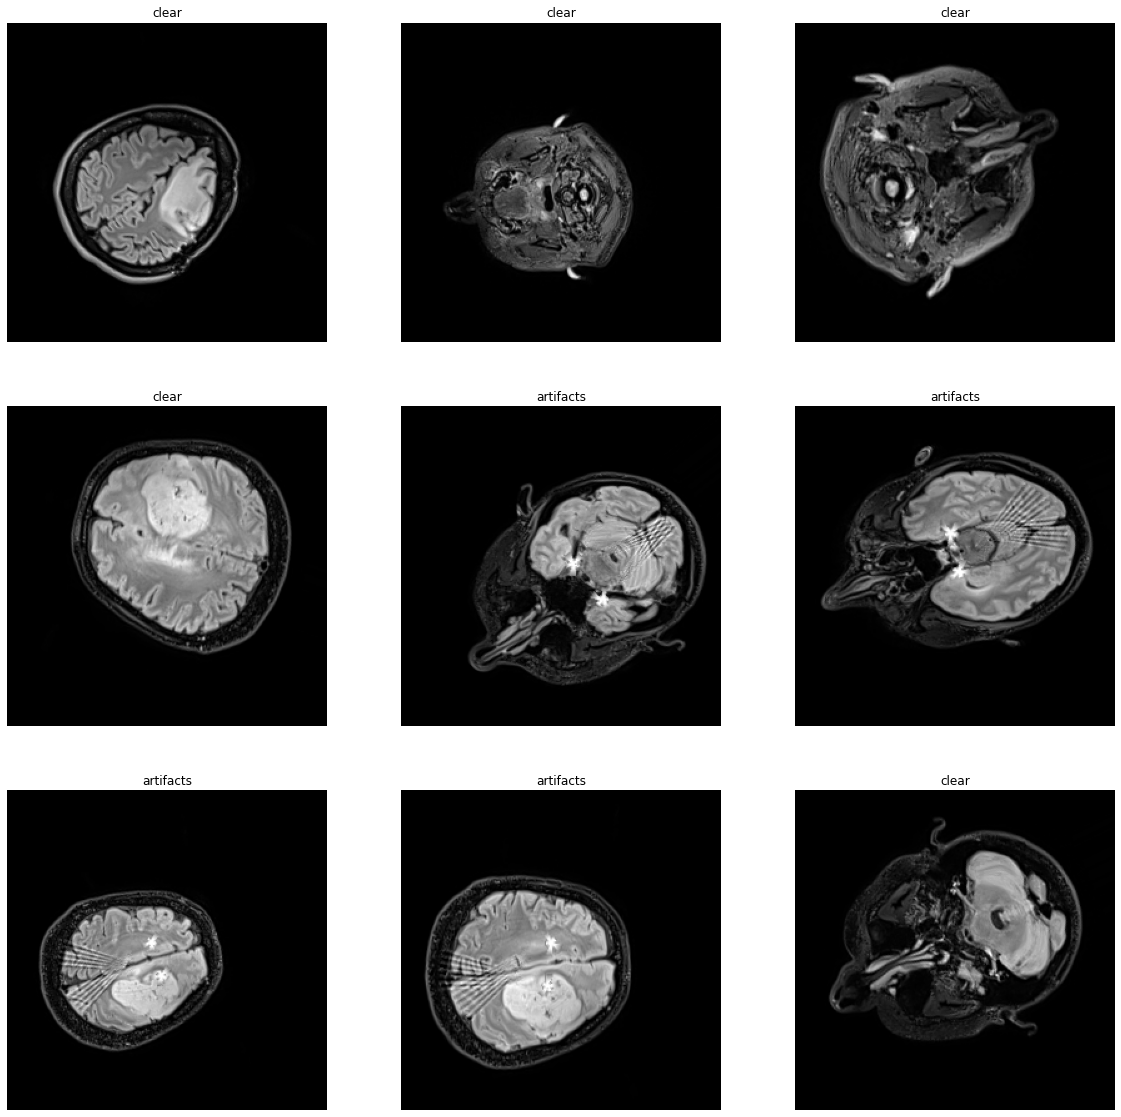

In [15]:
#%matplotlib notebook
#plt.figure(figsize=(10, 10))
plt.figure(figsize=(20, 20))
images, labels = train_generator.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"), cmap='gray')
    plt.title('clear' if int(labels[i])== 1 else 'artifacts'  )
    plt.axis("off")
plt.savefig(model_glowny_dir + 'prezentacja_danych.png')

## Build the convolutional neural network

In [13]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [14]:
train_generator.reset()
validation_generator.reset()

model = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
#     Dropout(0.25),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

#    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_glowny_dir + '/checkpoint',
    save_weights_only=False,
    monitor='val_loss', 
    mode='min', # mam loss wiec min
    save_best_only=True)

callbacks = [
         EarlyStopping(patience=5),
         model_checkpoint_callback
]
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

hist = model.fit(train_generator, validation_data=validation_generator, epochs=60, callbacks=callbacks)

model.save(model_glowny_dir + "model.h5")
pd.DataFrame.from_dict(hist.history).to_csv(model_glowny_dir + "history.csv", index=False)

Epoch 1/60


C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


15/15 [==============================] - 4s 183ms/step - loss: 0.7038 - accuracy: 0.5011 - precision: 0.5015 - recall: 0.7380 - auc: 0.4897 - val_loss: 0.6938 - val_accuracy: 0.3800 - val_precision: 0.3636 - val_recall: 0.3200 - val_auc: 0.5000
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/Praca dyplomowa/work_dir/model_glowny\checkpoint\assets
Epoch 2/60
15/15 [==============================] - 2s 140ms/step - loss: 0.6939 - accuracy: 0.5055 - precision: 0.5600 - recall: 0.0611 - auc: 0.4786 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5096
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/Praca dyplomowa/work_dir/model_glowny\checkpoint\assets
Epoch 3/60
15/15 [==============================] - 2s 141ms/step - loss: 0.6930 - accuracy: 0.4989 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5100 - val_loss: 0.6916 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - v

##  Visualize a deep learning model 

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, None, None, None)  0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0

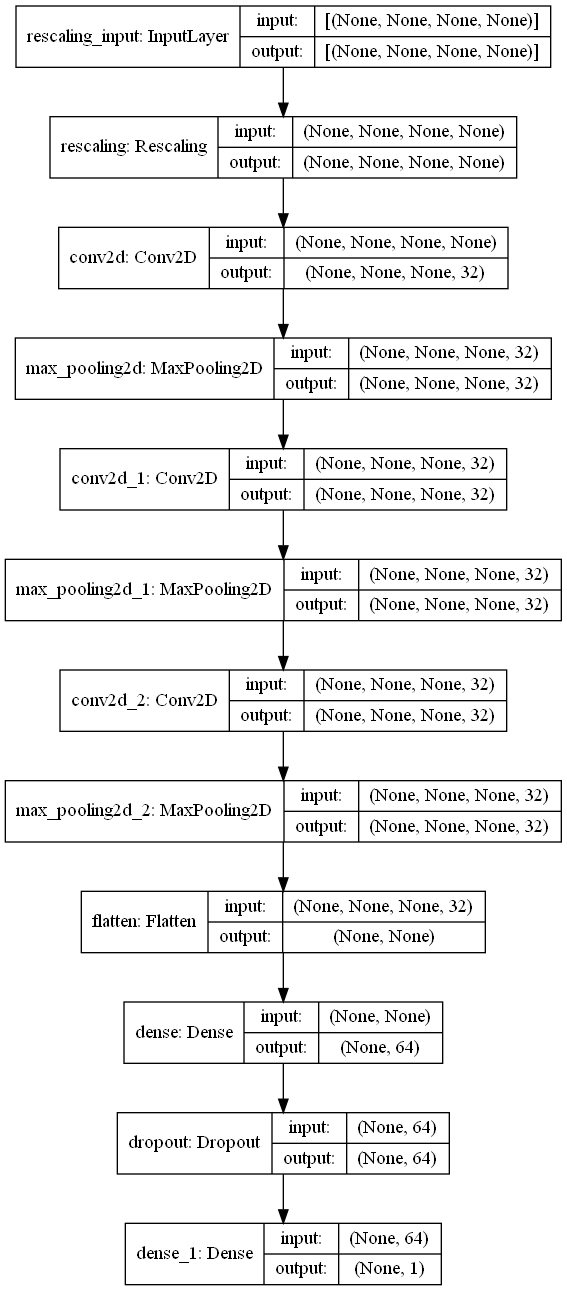

In [16]:
tf.keras.utils.plot_model(
    model,
    to_file=model_glowny_dir+ "/model_glowny.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## Monitoring the model’s performance


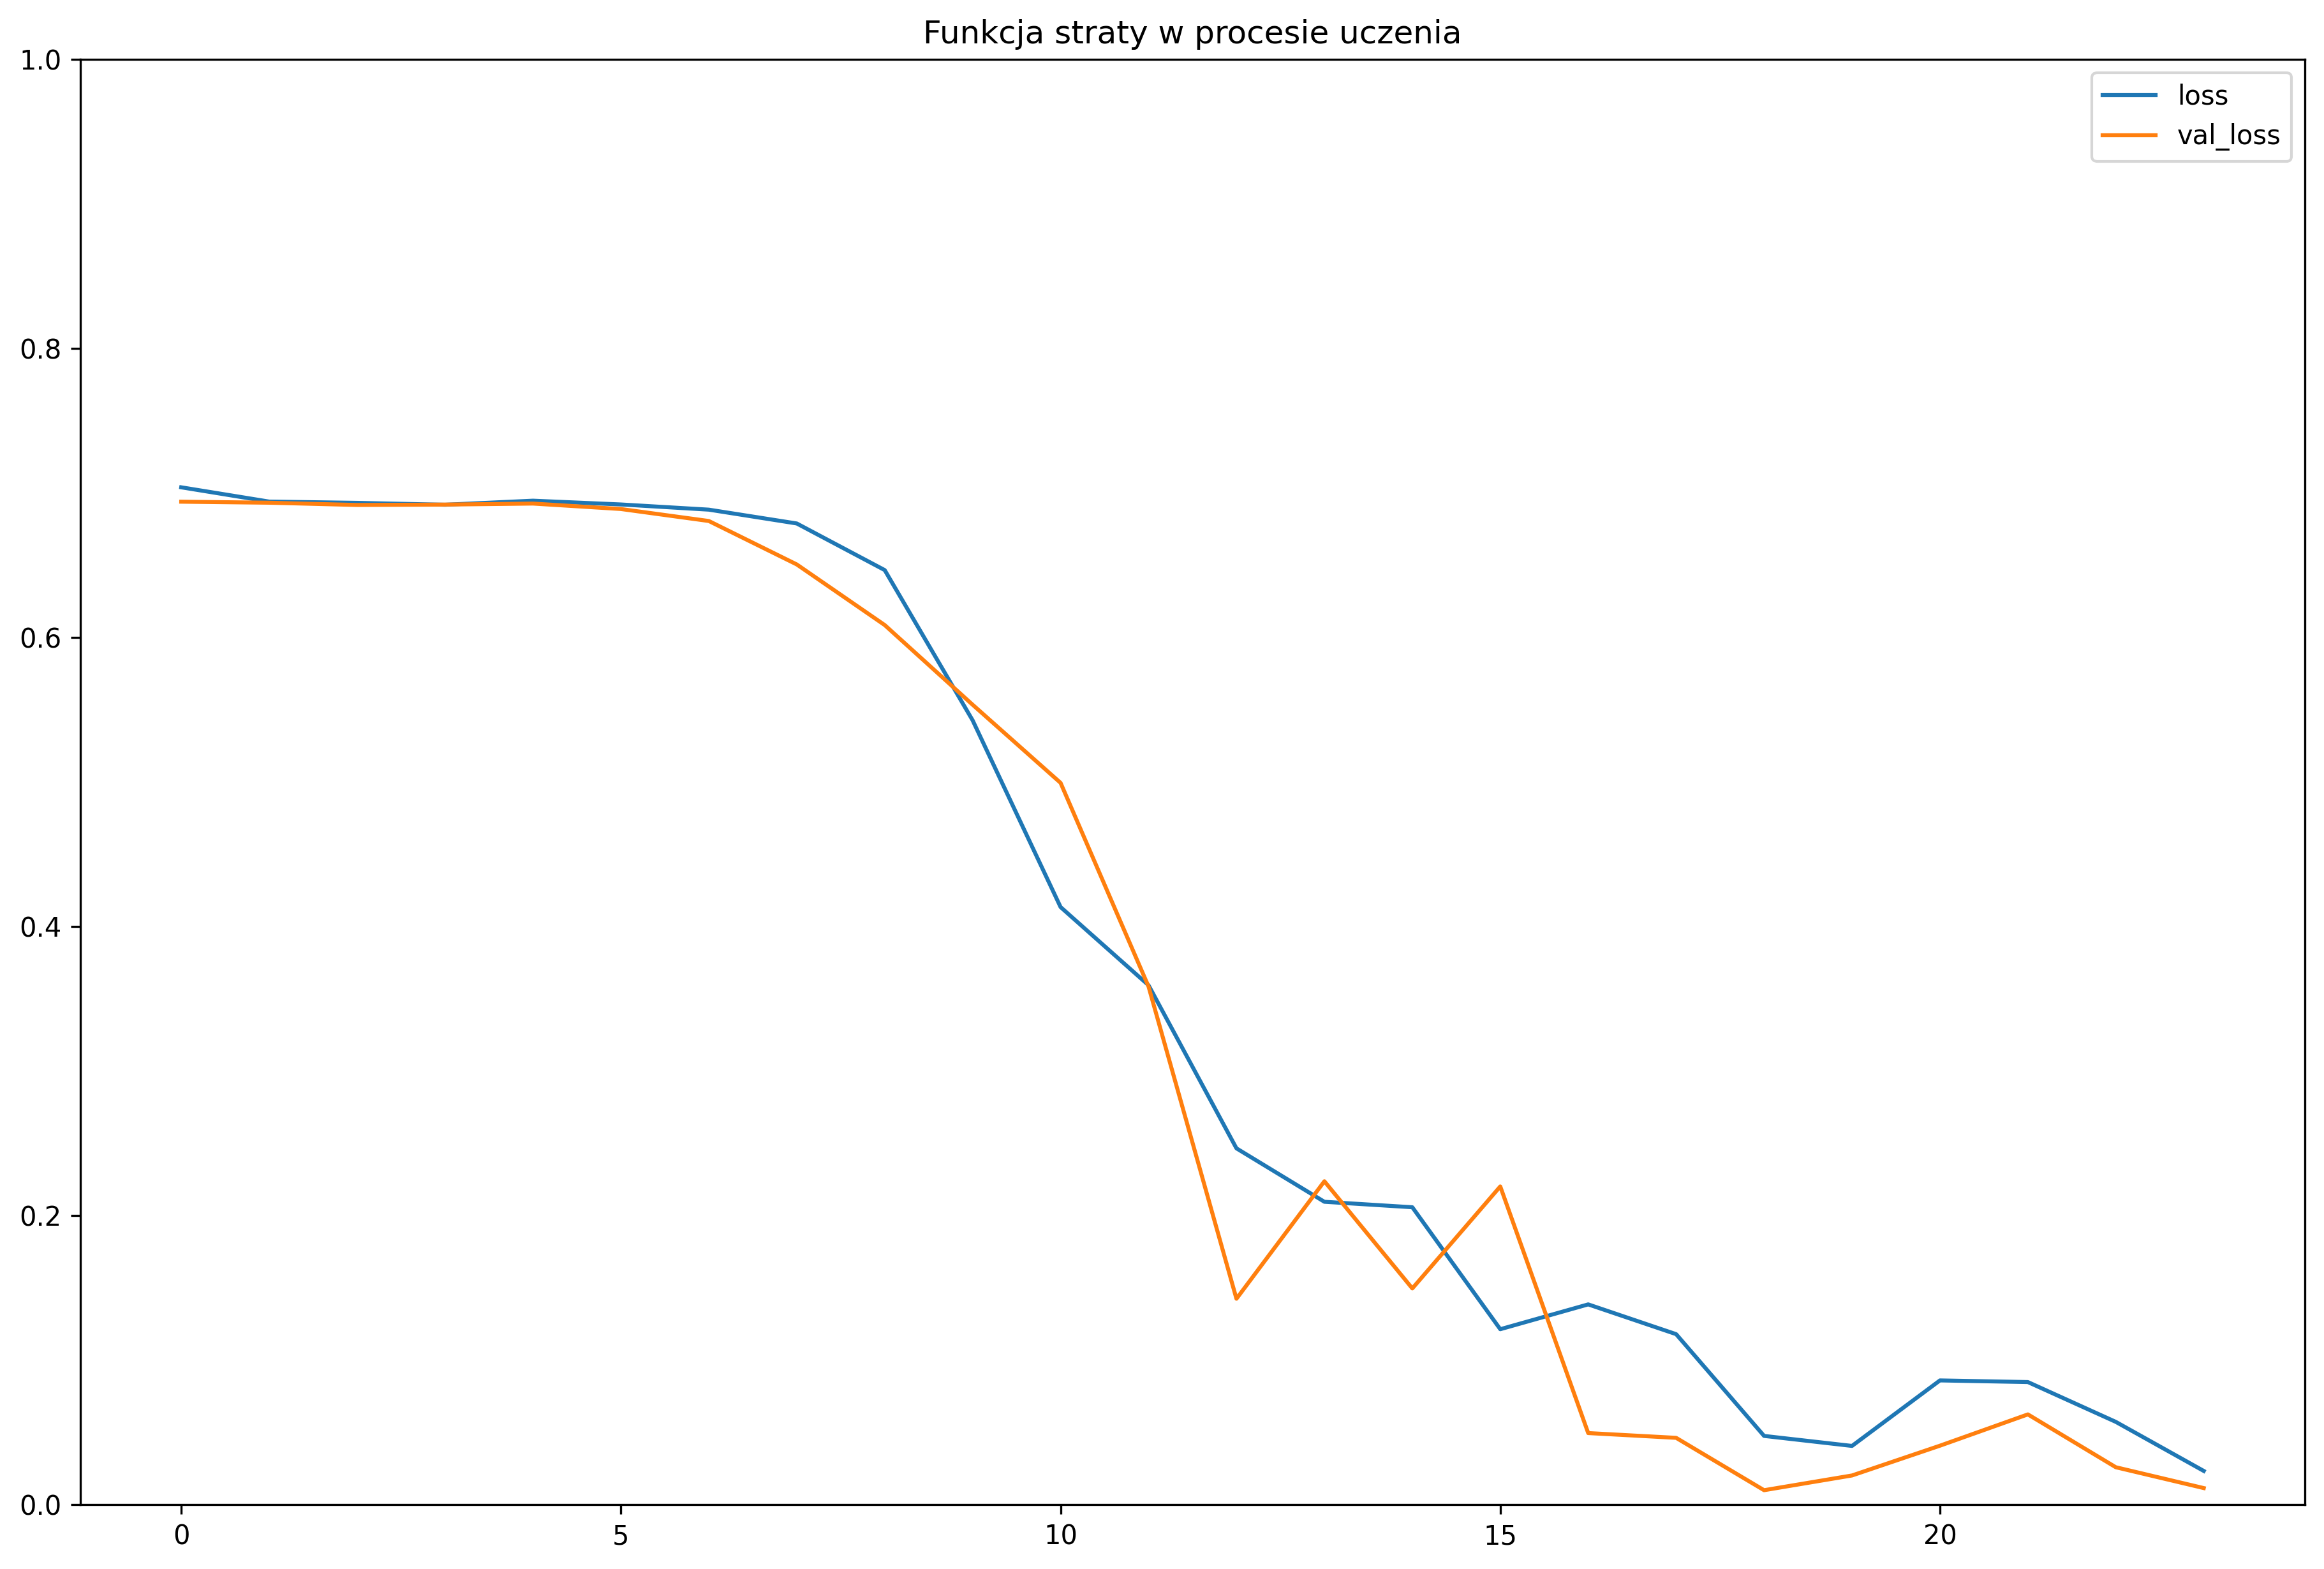

In [17]:
# Funkcja straty
fig = plt.figure(figsize=(15, 10))
#fig.suptitle('Funkcja straty w procesie uczenia', fontsize=16)
fig.set_dpi(300)
metrics_df = pd.DataFrame(hist.history)
ax = plt.subplot(1, 1, 1)
ax.set(ylim =(0, 1.0))
ax.plot(metrics_df[["loss","val_loss"]])
ax.legend(["loss","val_loss"])
ax.set_title('Funkcja straty w procesie uczenia')
plt.show()
fig.savefig(model_glowny_dir + 'Funkcja straty w procesie uczenia.png')

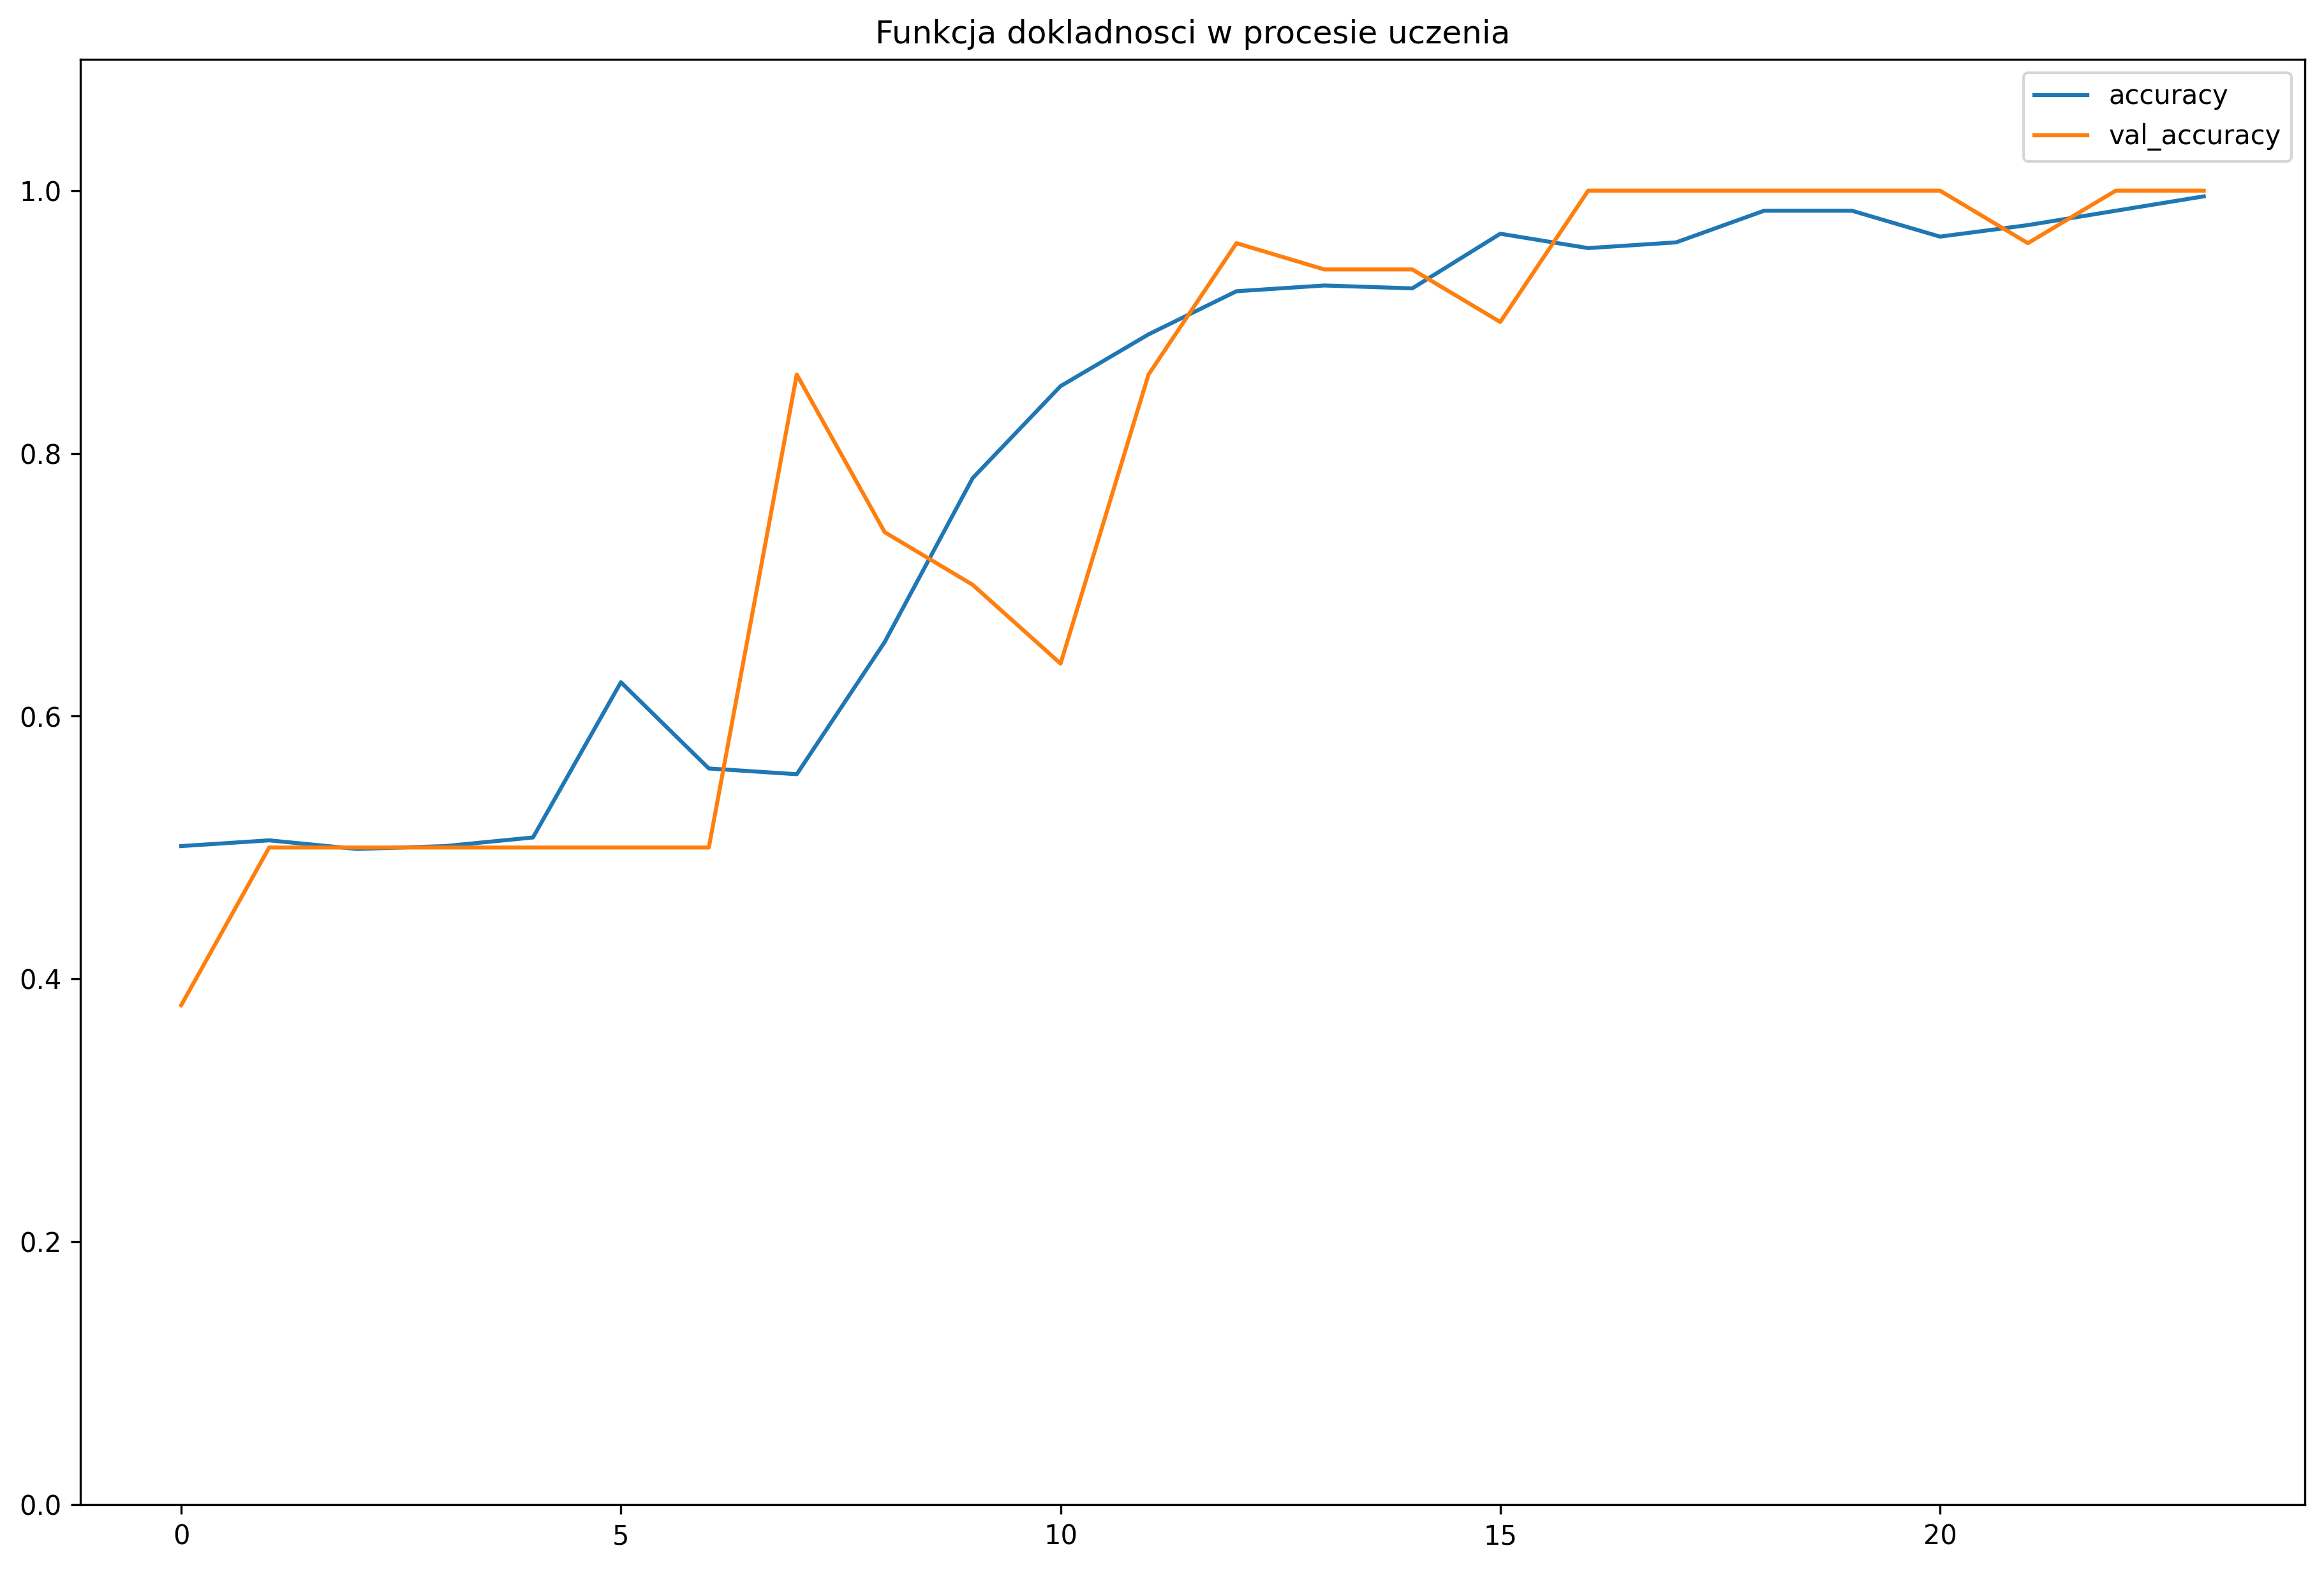

In [18]:
# Dokladnosc modelu
fig = plt.figure(figsize=(15, 10))
fig.set_dpi(300)
metrics_df = pd.DataFrame(hist.history)
ax = plt.subplot(1, 1, 1)
ax.set(ylim =(0, 1.1))
ax.plot(metrics_df[["accuracy","val_accuracy"]])
ax.legend(["accuracy","val_accuracy"])
ax.set_title('Funkcja dokladnosci w procesie uczenia')
plt.show()
fig.savefig(model_glowny_dir + 'Funkcja dokladnosci w procesie uczenia.png')

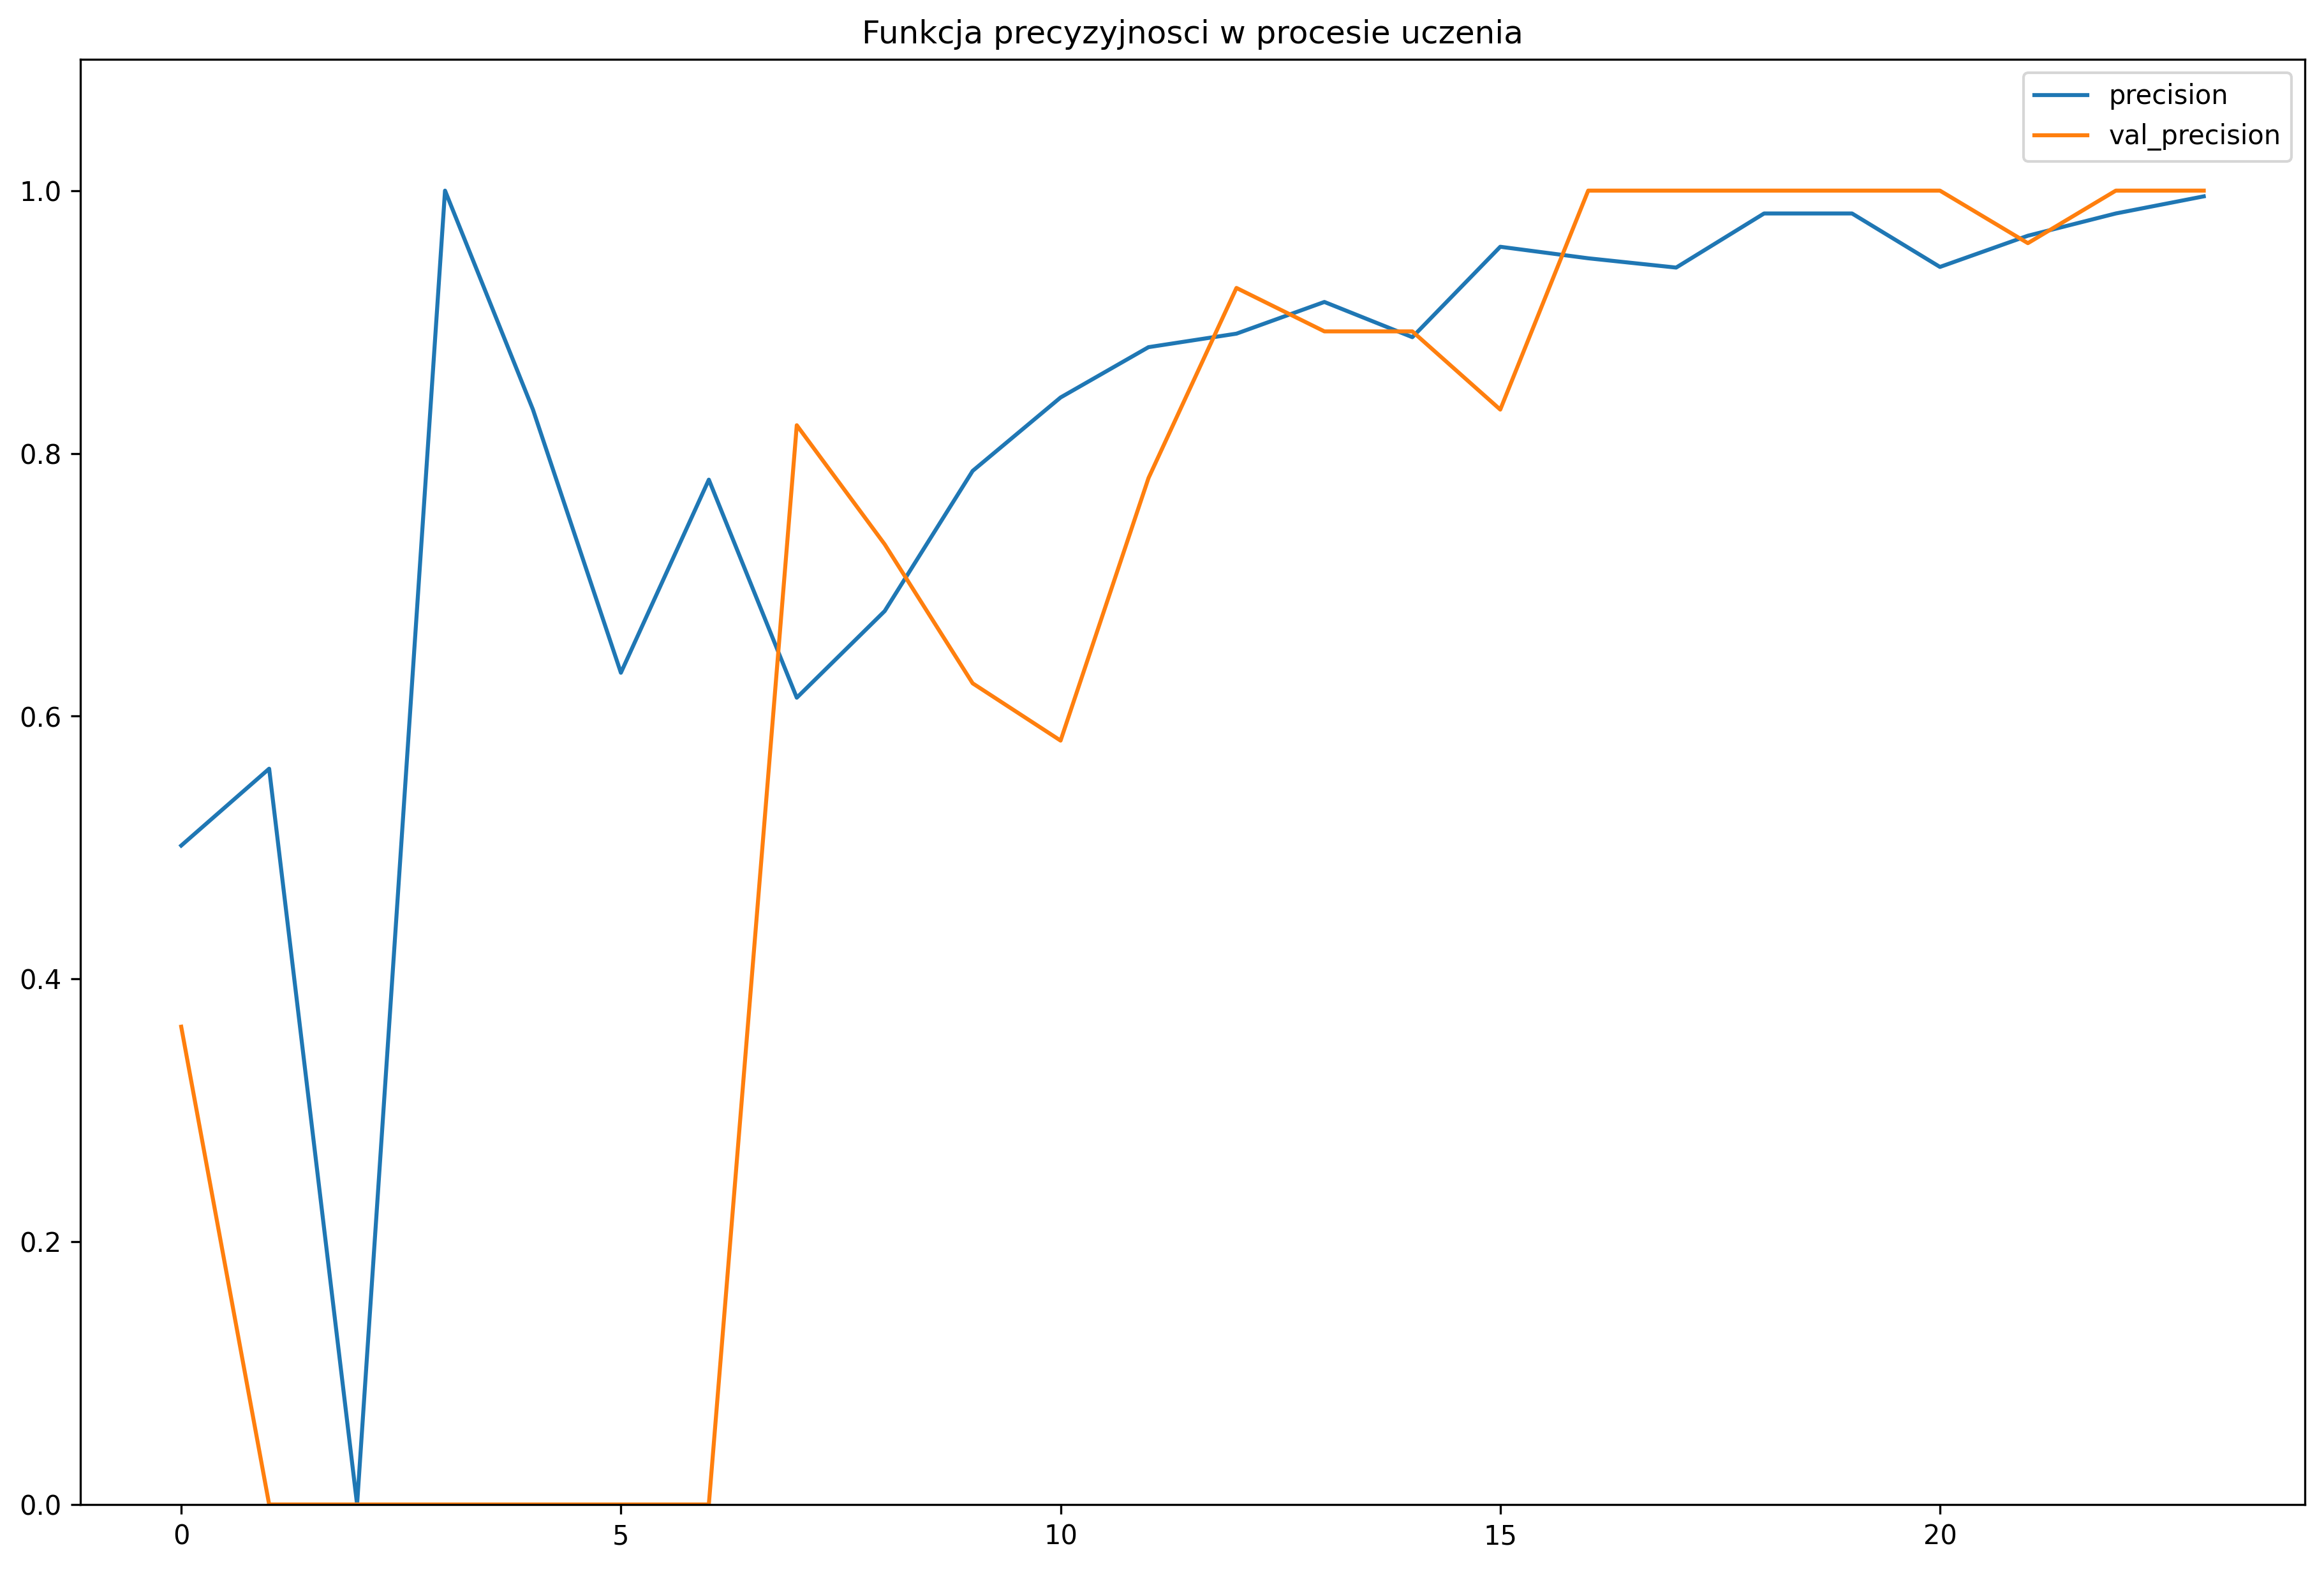

In [19]:
# Precyzyjnosc modelu
fig = plt.figure(figsize=(15, 10))
fig.set_dpi(300)
metrics_df = pd.DataFrame(hist.history)
ax = plt.subplot(1, 1, 1)
ax.set(ylim =(0, 1.1))
ax.plot(metrics_df[["precision","val_precision"]])
ax.legend(["precision","val_precision"])
ax.set_title('Funkcja precyzyjnosci w procesie uczenia')
plt.show()
fig.savefig(model_glowny_dir + 'Funkcja precyzyjnosci w procesie uczenia.png')

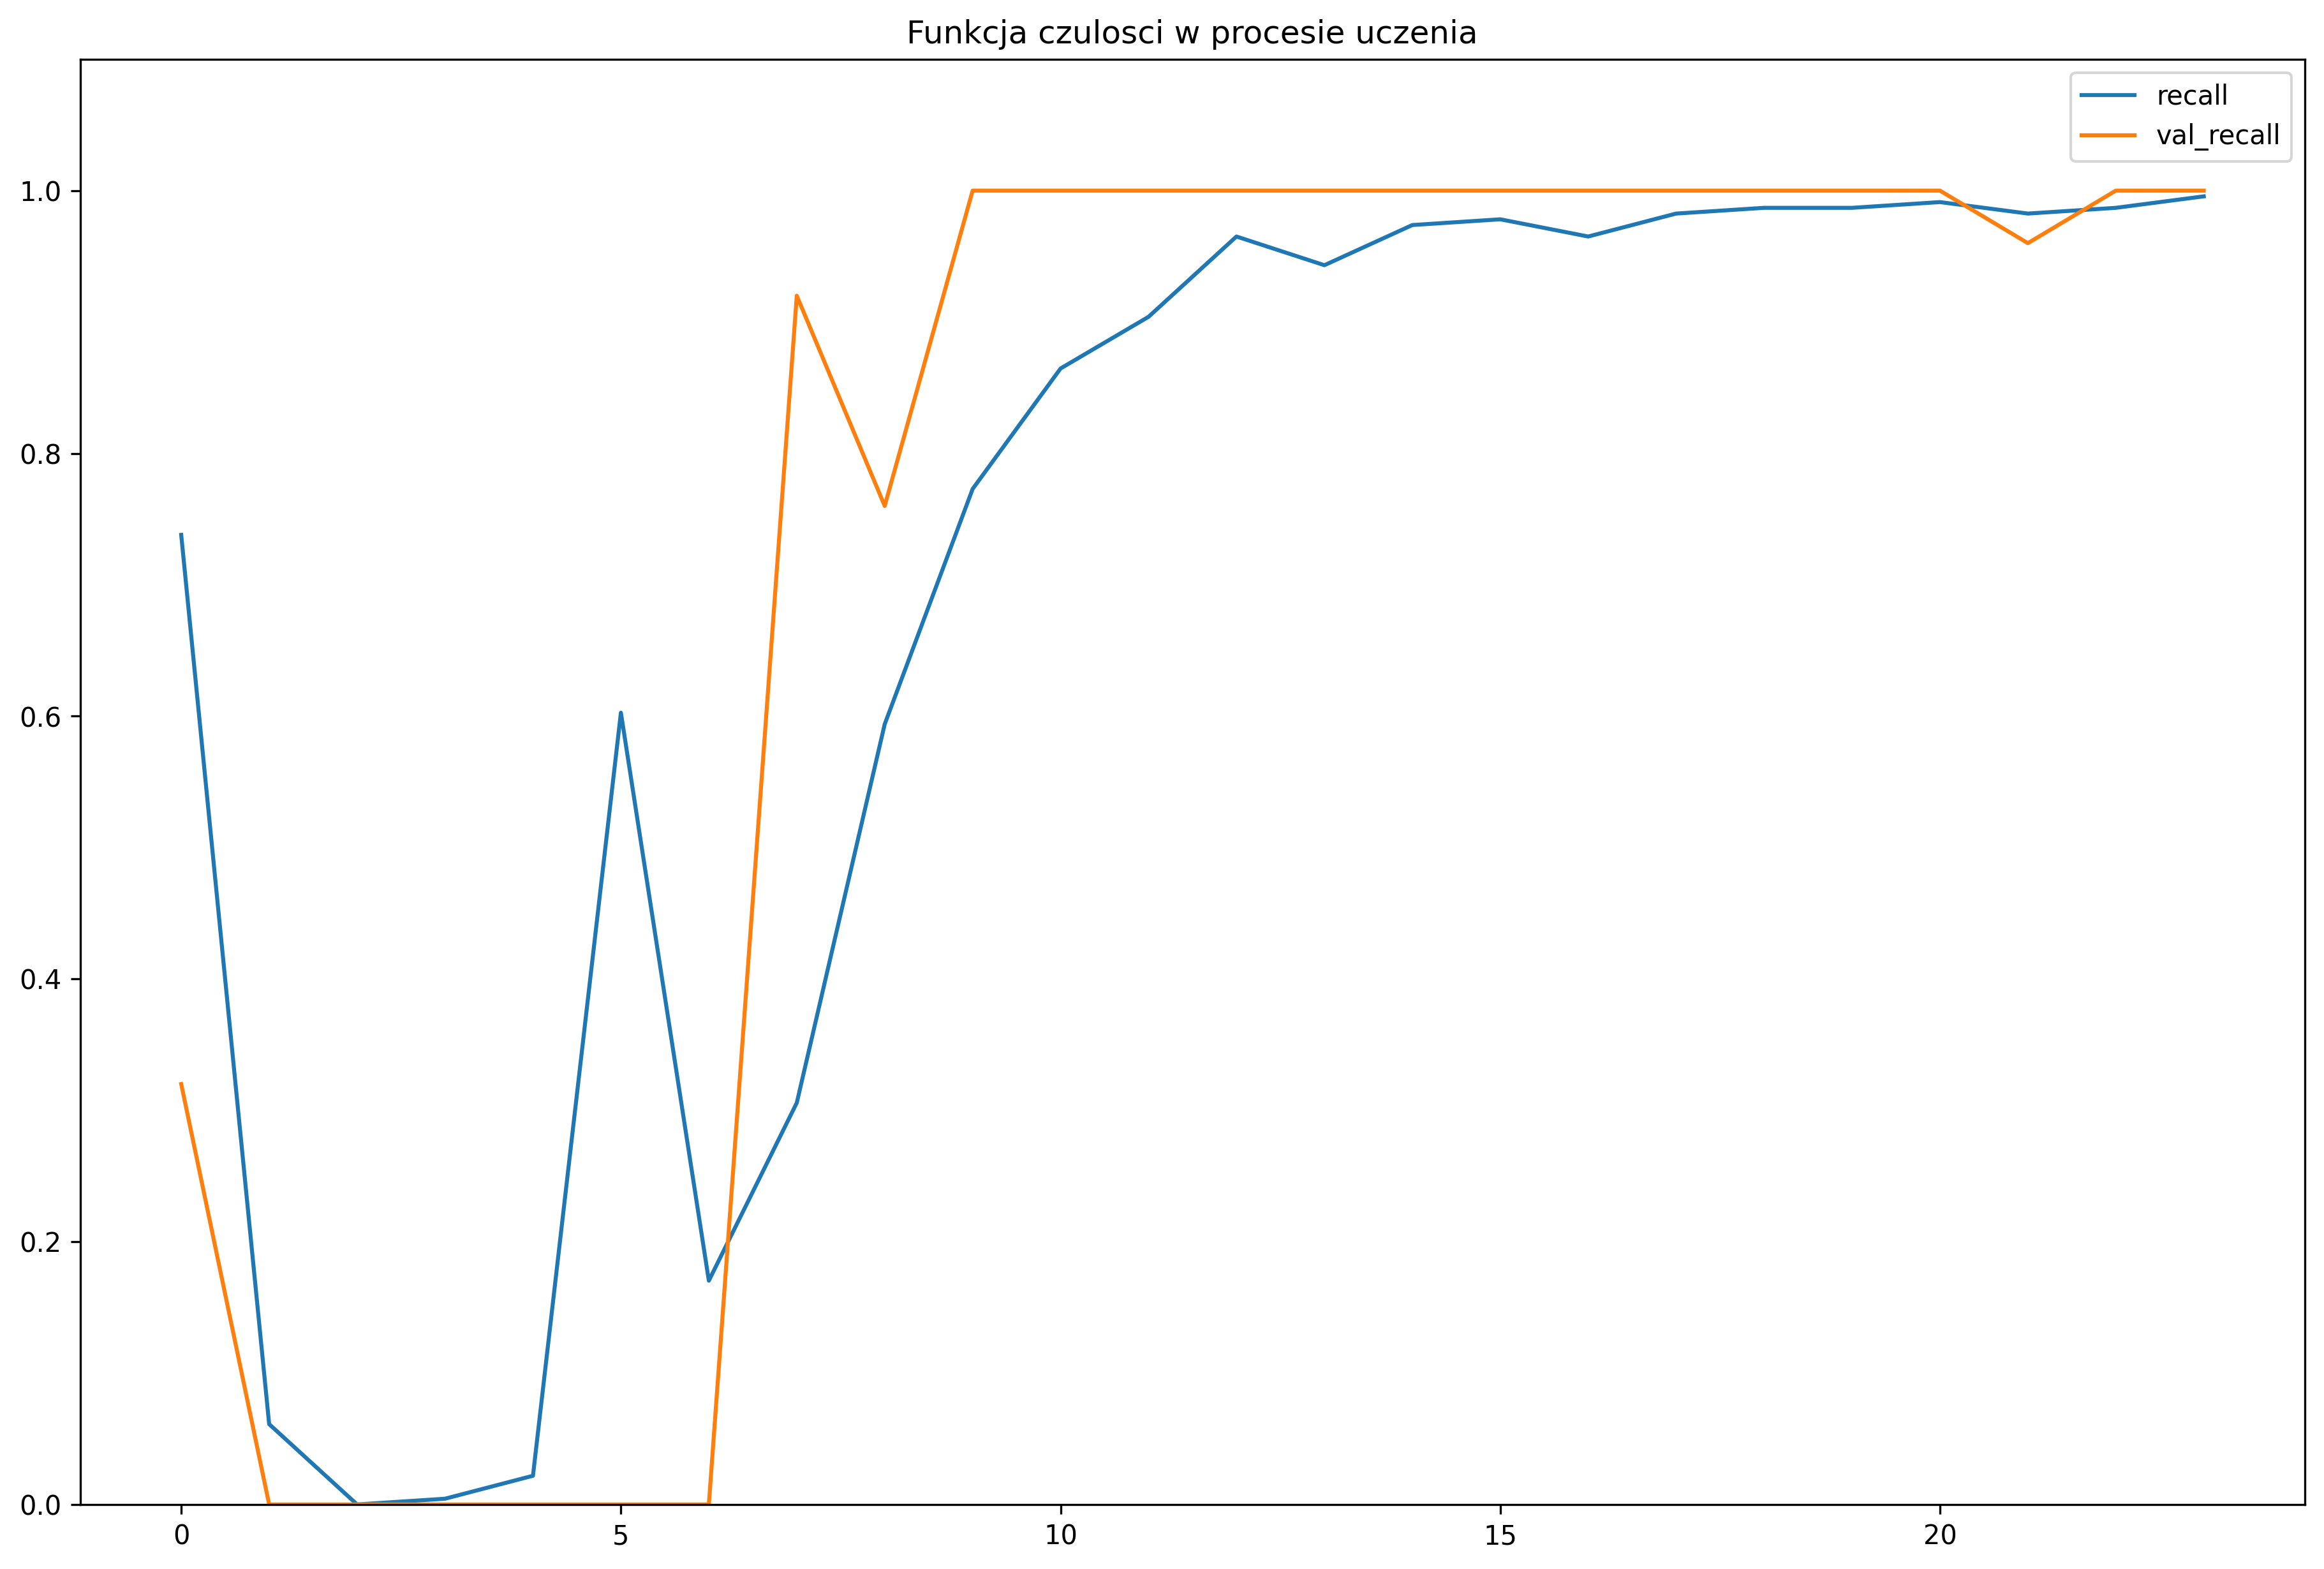

In [20]:
#Czulosc modelu
fig = plt.figure(figsize=(15, 10))
fig.set_dpi(300)
metrics_df = pd.DataFrame(hist.history)
ax = plt.subplot(1, 1, 1)
ax.set(ylim =(0, 1.1))
ax.plot(metrics_df[["recall","val_recall"]])
ax.legend(["recall","val_recall"])
ax.set_title('Funkcja czulosci w procesie uczenia')
plt.show()
fig.savefig(model_glowny_dir + 'Funkcja czulosci w procesie uczenia.png')

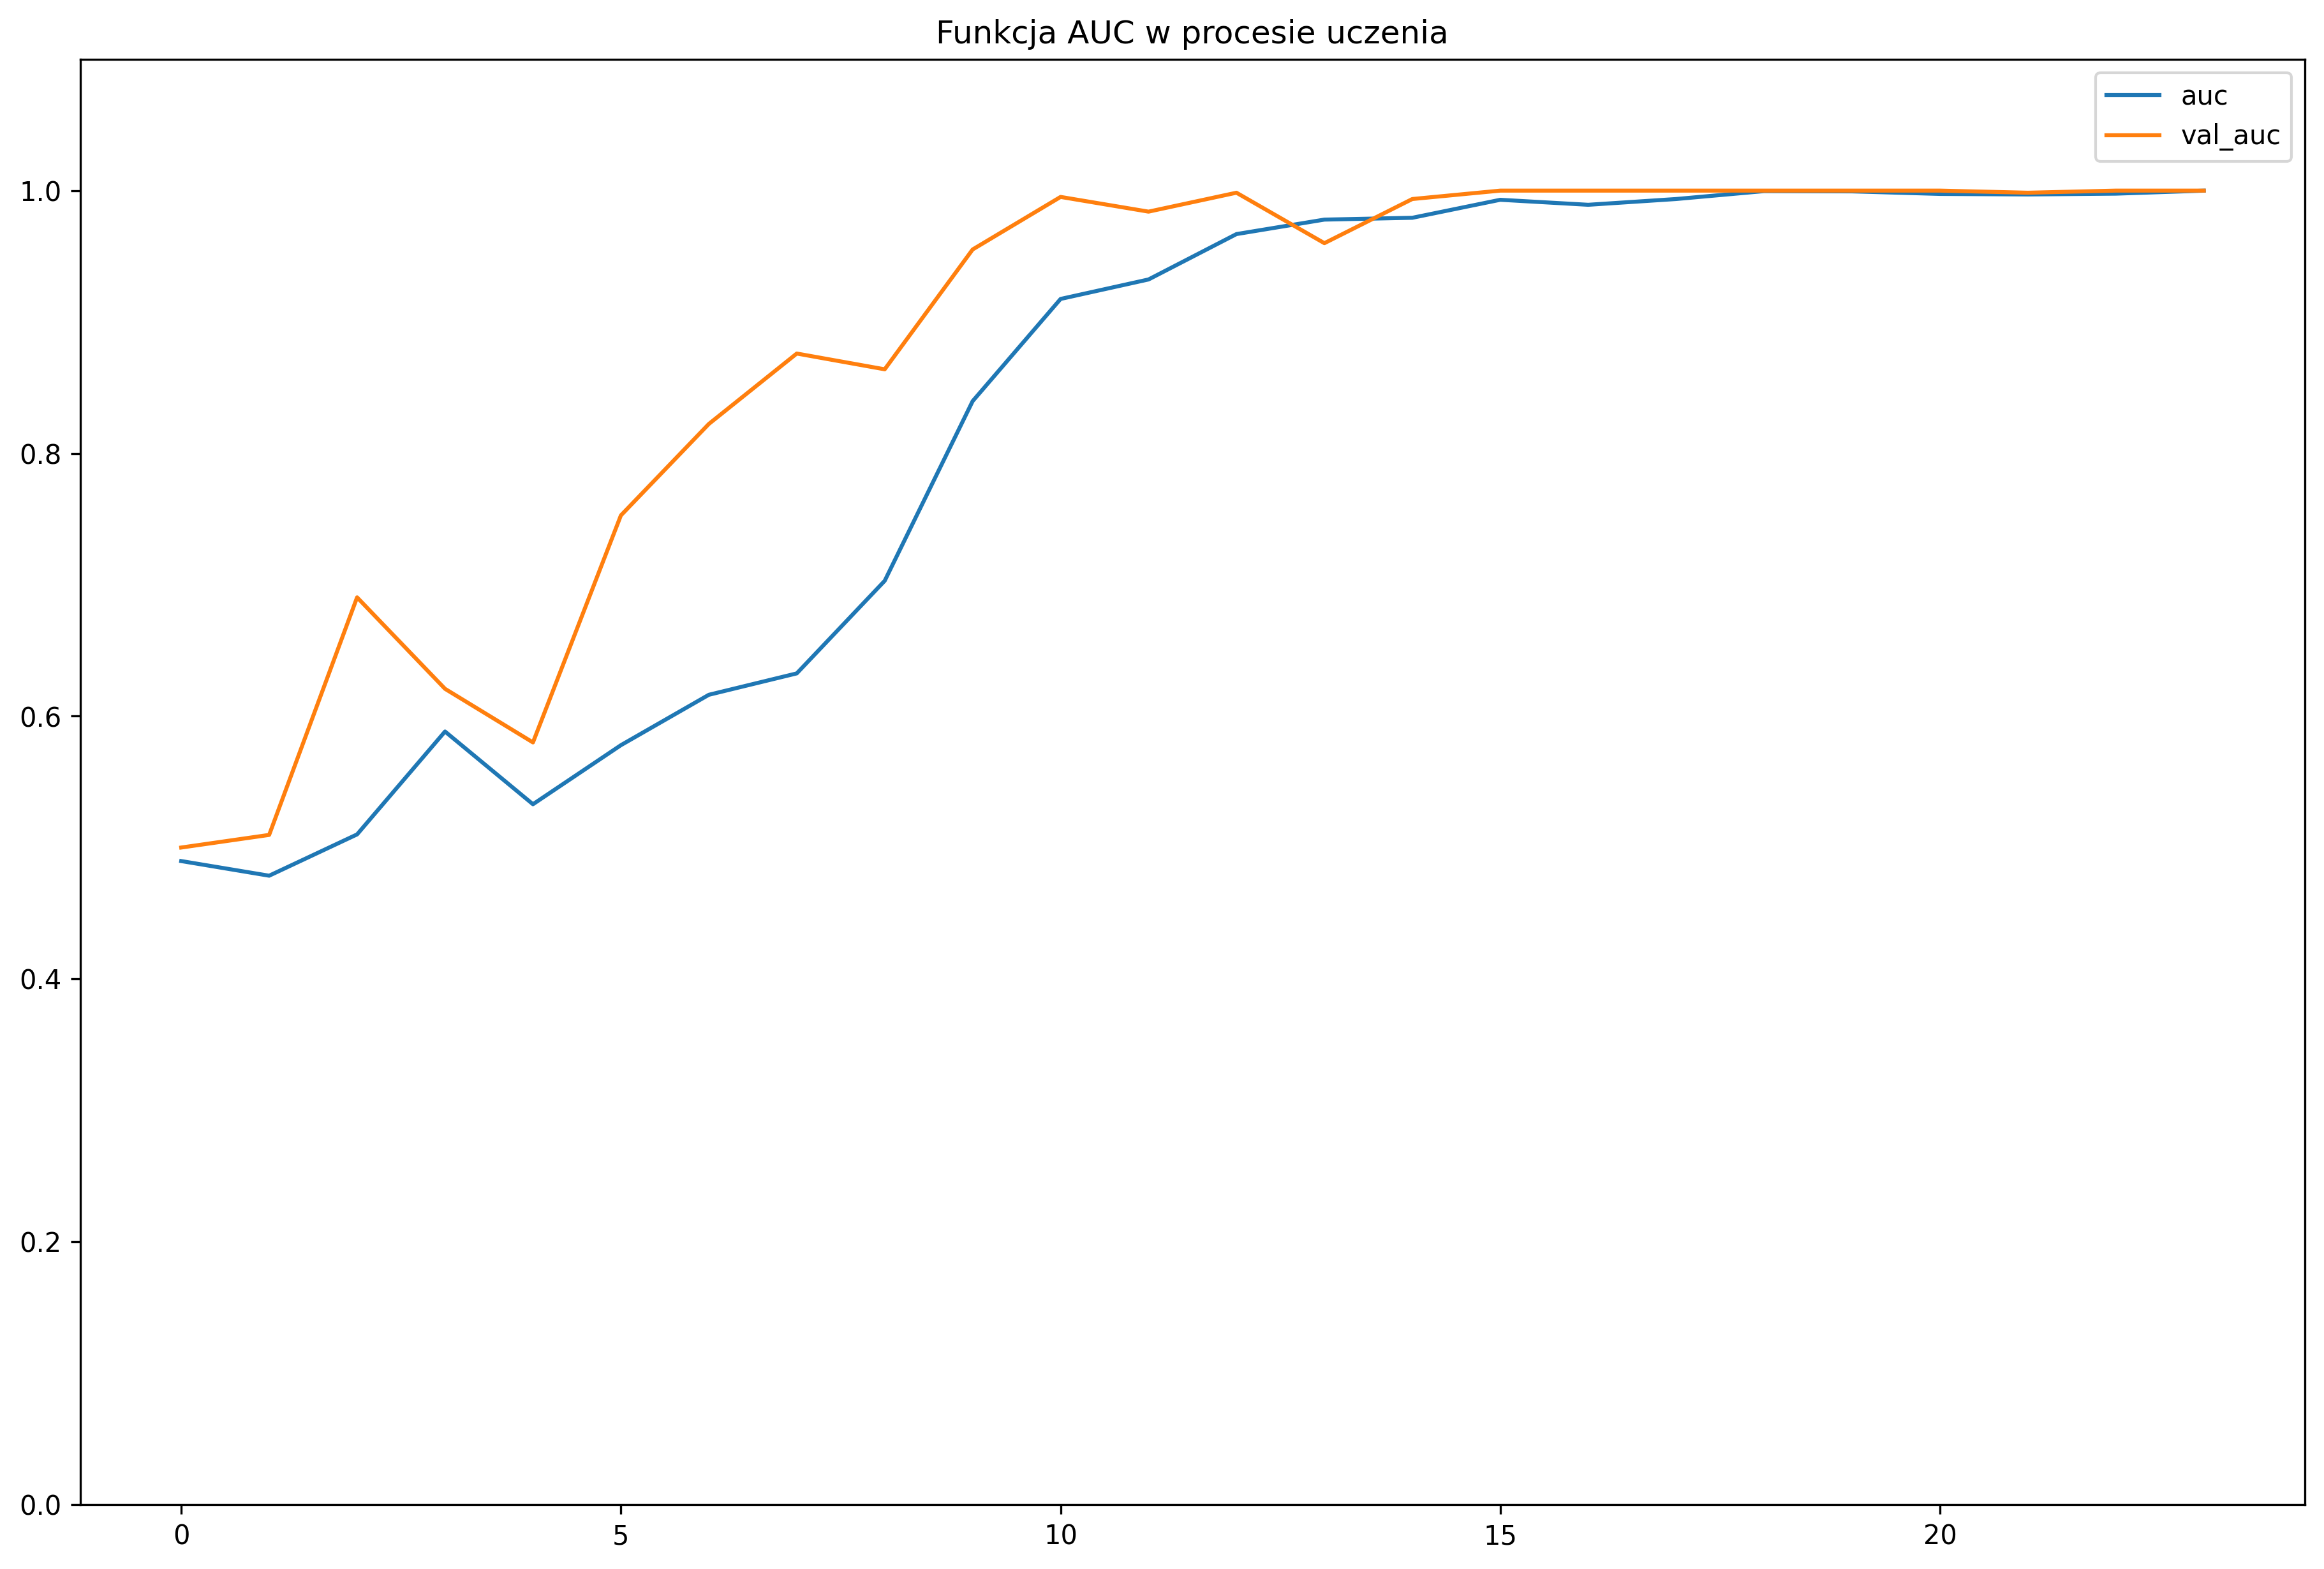

In [21]:
#AUC modelu
fig = plt.figure(figsize=(15, 10))
fig.set_dpi(300)
metrics_df = pd.DataFrame(hist.history)
ax = plt.subplot(1, 1, 1)
ax.set(ylim =(0, 1.1))
ax.plot(metrics_df[["auc","val_auc"]])
ax.legend(["auc","val_auc"])
ax.set_title('Funkcja AUC w procesie uczenia')
plt.show()
fig.savefig(model_glowny_dir + 'Funkcja AUC w procesie uczenia.png')

## Checking the performance of the model on the validation set

In [22]:
validation_generator.reset()
res = model.evaluate(validation_generator)

2/2 [==============================] - 0s 94ms/step - loss: 0.0108 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000


## Checking the model on the test set

In [23]:
test_generator.reset()
res = model.evaluate(test_generator)

57/57 [==============================] - 1s 5ms/step - loss: 0.0110 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000        


[0.011031958274543285, 1.0, 1.0, 1.0, 1.0]

True positive: 195 True negative: 202 False Positive: 1 False negative: 2


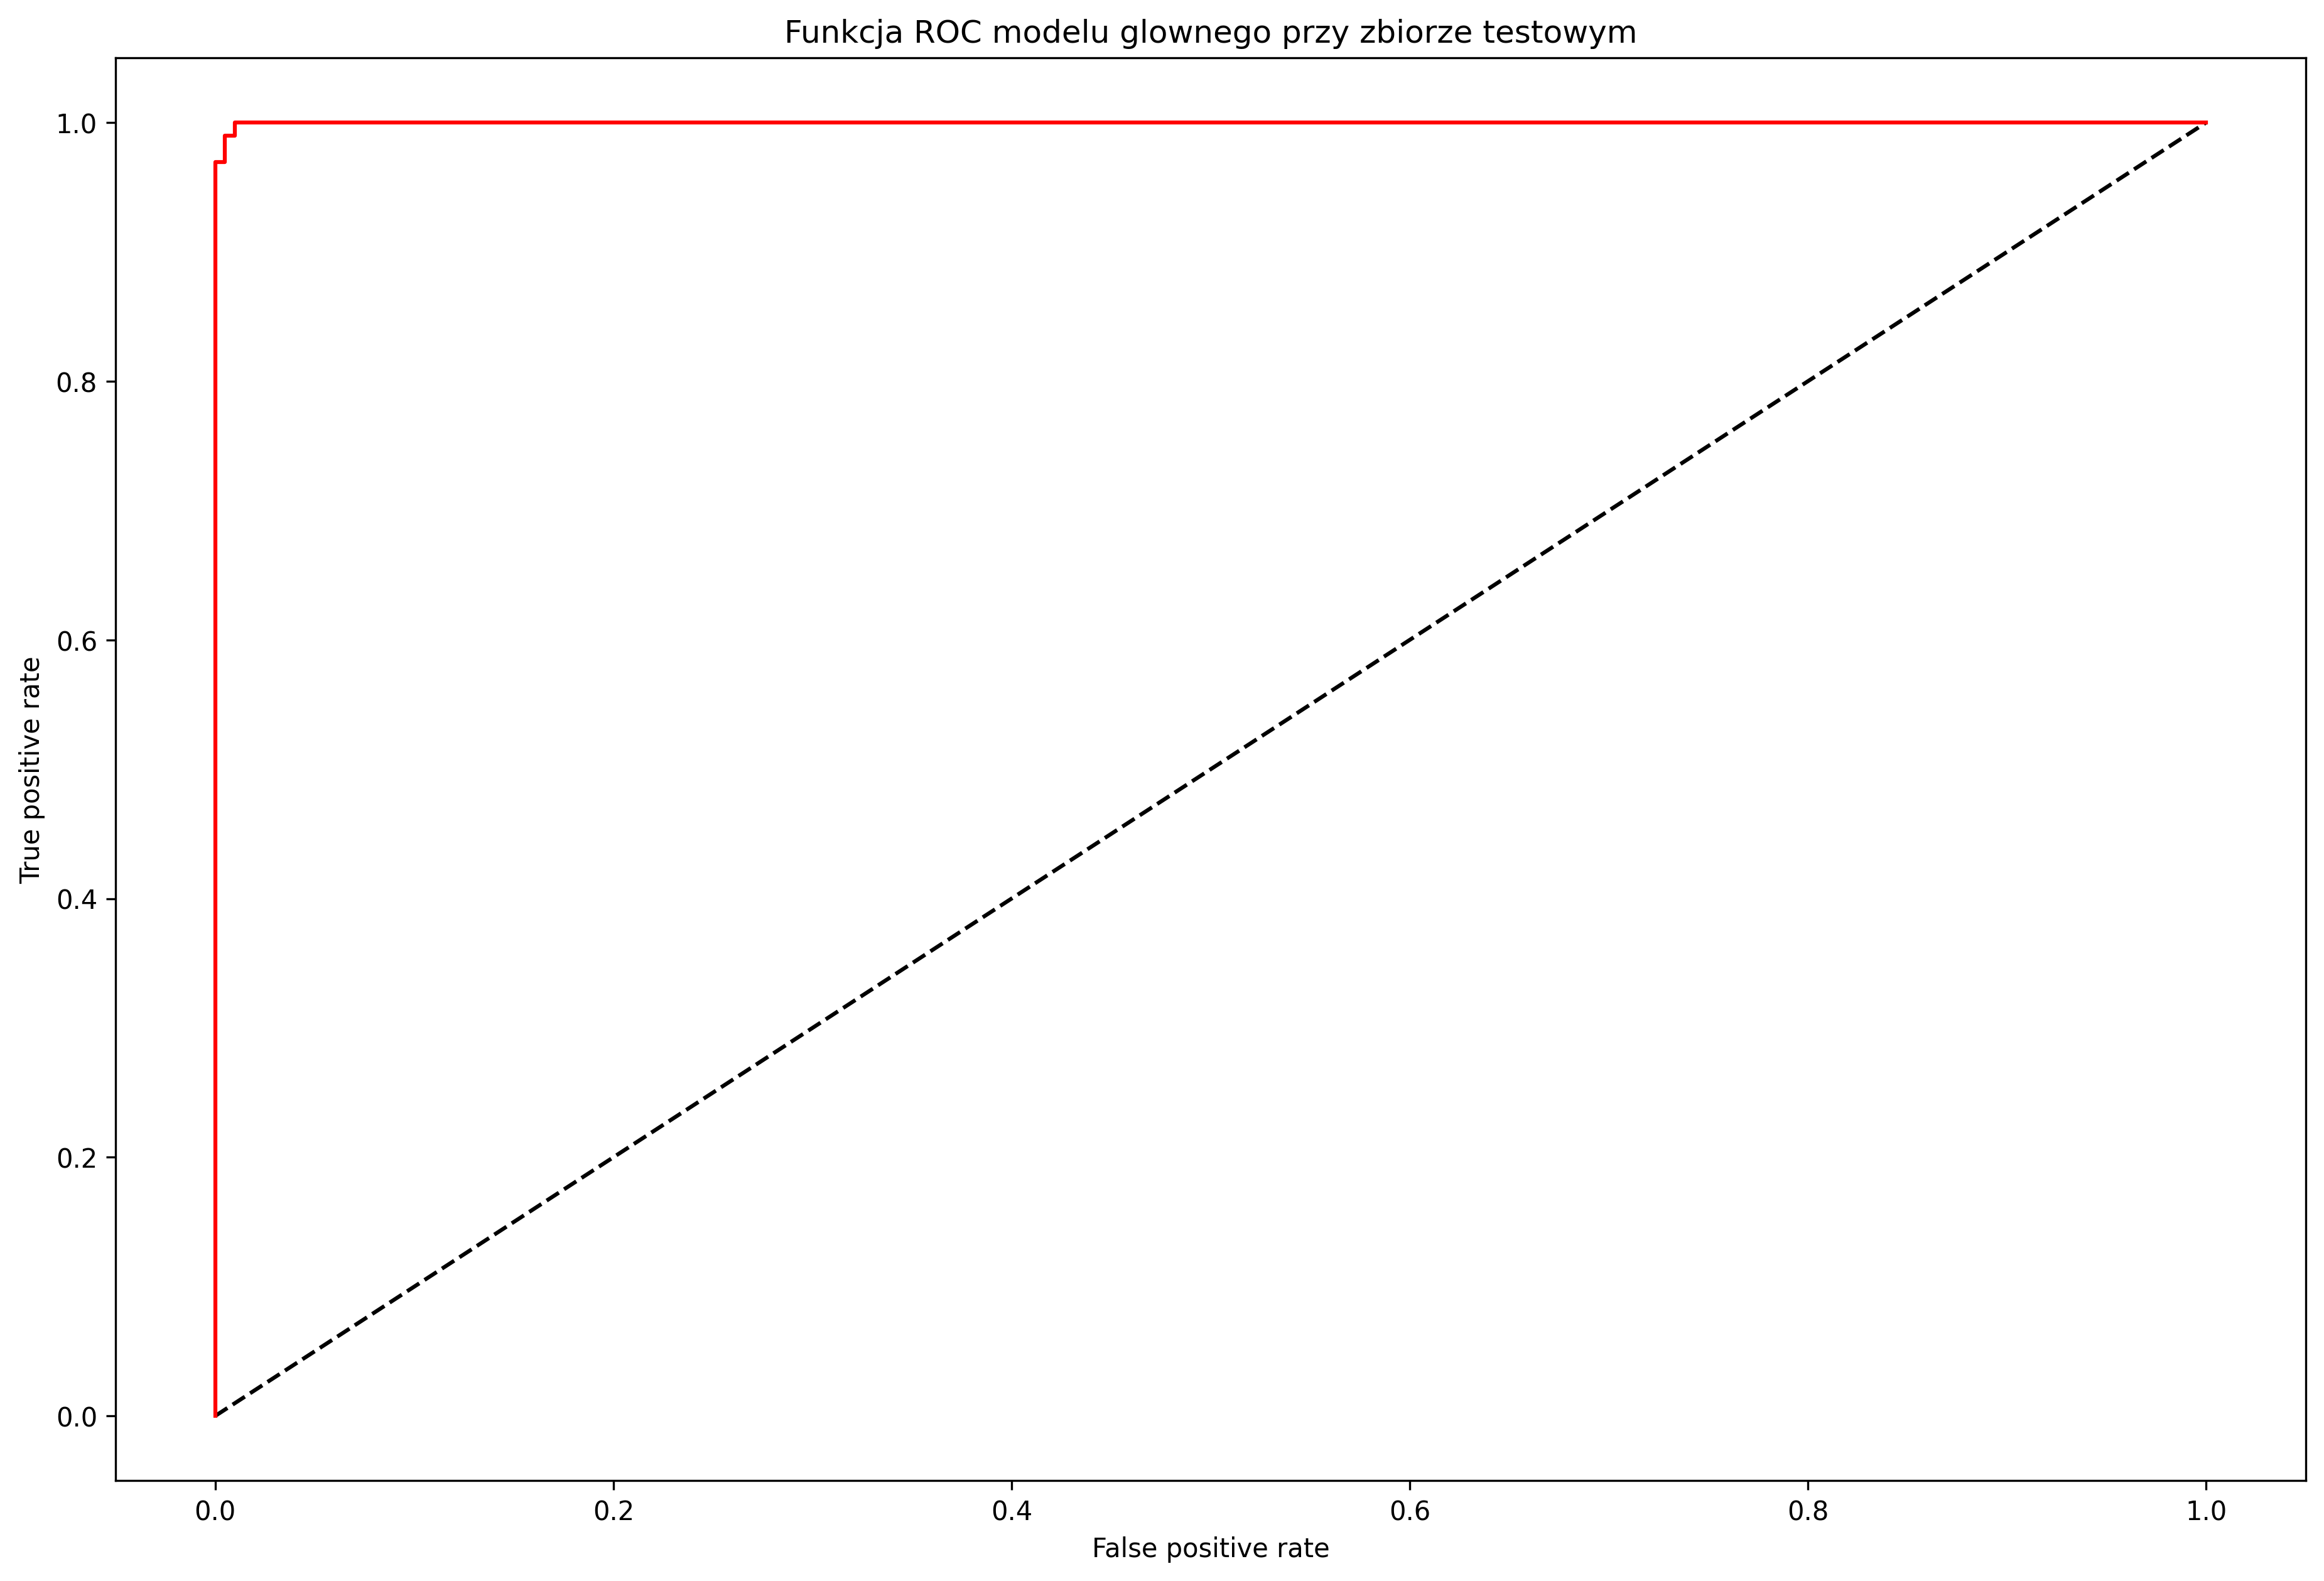

In [24]:
test_generator.reset()

tp = 0
tn = 0
fp = 0
fn = 0
threshold = 0.5
y_predict = []
y_true = []

for _ in range(400):
    image, labels = test_generator.next()
    true_label = int(labels[0])
    prediction = model.predict(image)[0][0]

    y_predict.append(prediction)
    y_true.append(true_label)

    if prediction >= threshold:
        if true_label == 1:
            tp = tp + 1
        else:
            fp = fp + 1
    else:
        if true_label == 0:
            tn = tn + 1
        else:
            fn = fn + 1

print("True positive: {} True negative: {} False Positive: {} False negative: {}".format(tp, tn, fp, fn))

#ROC modelu
fpr, tpr, thresholds = roc_curve(y_true, y_predict)
fig = plt.figure(figsize=(15, 10))
fig.set_dpi(300)
ax = plt.subplot(1, 1, 1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr, 'r')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Funkcja ROC modelu glownego przy zbiorze testowym')
plt.show()
fig.savefig(model_glowny_dir + 'Funkcja ROC modelu glownego przy zbiorze testowym.png')

## Test gwiazdki oddalone

In [31]:
path_test_2 = model_glowny_dir + "test_oddalone"
test_generator_2 = data_gen_test.flow_from_directory(path_test_2, **flow_parameters_test)

Found 564 images belonging to 2 classes.


True positive: 204 True negative: 187 False Positive: 9 False negative: 0


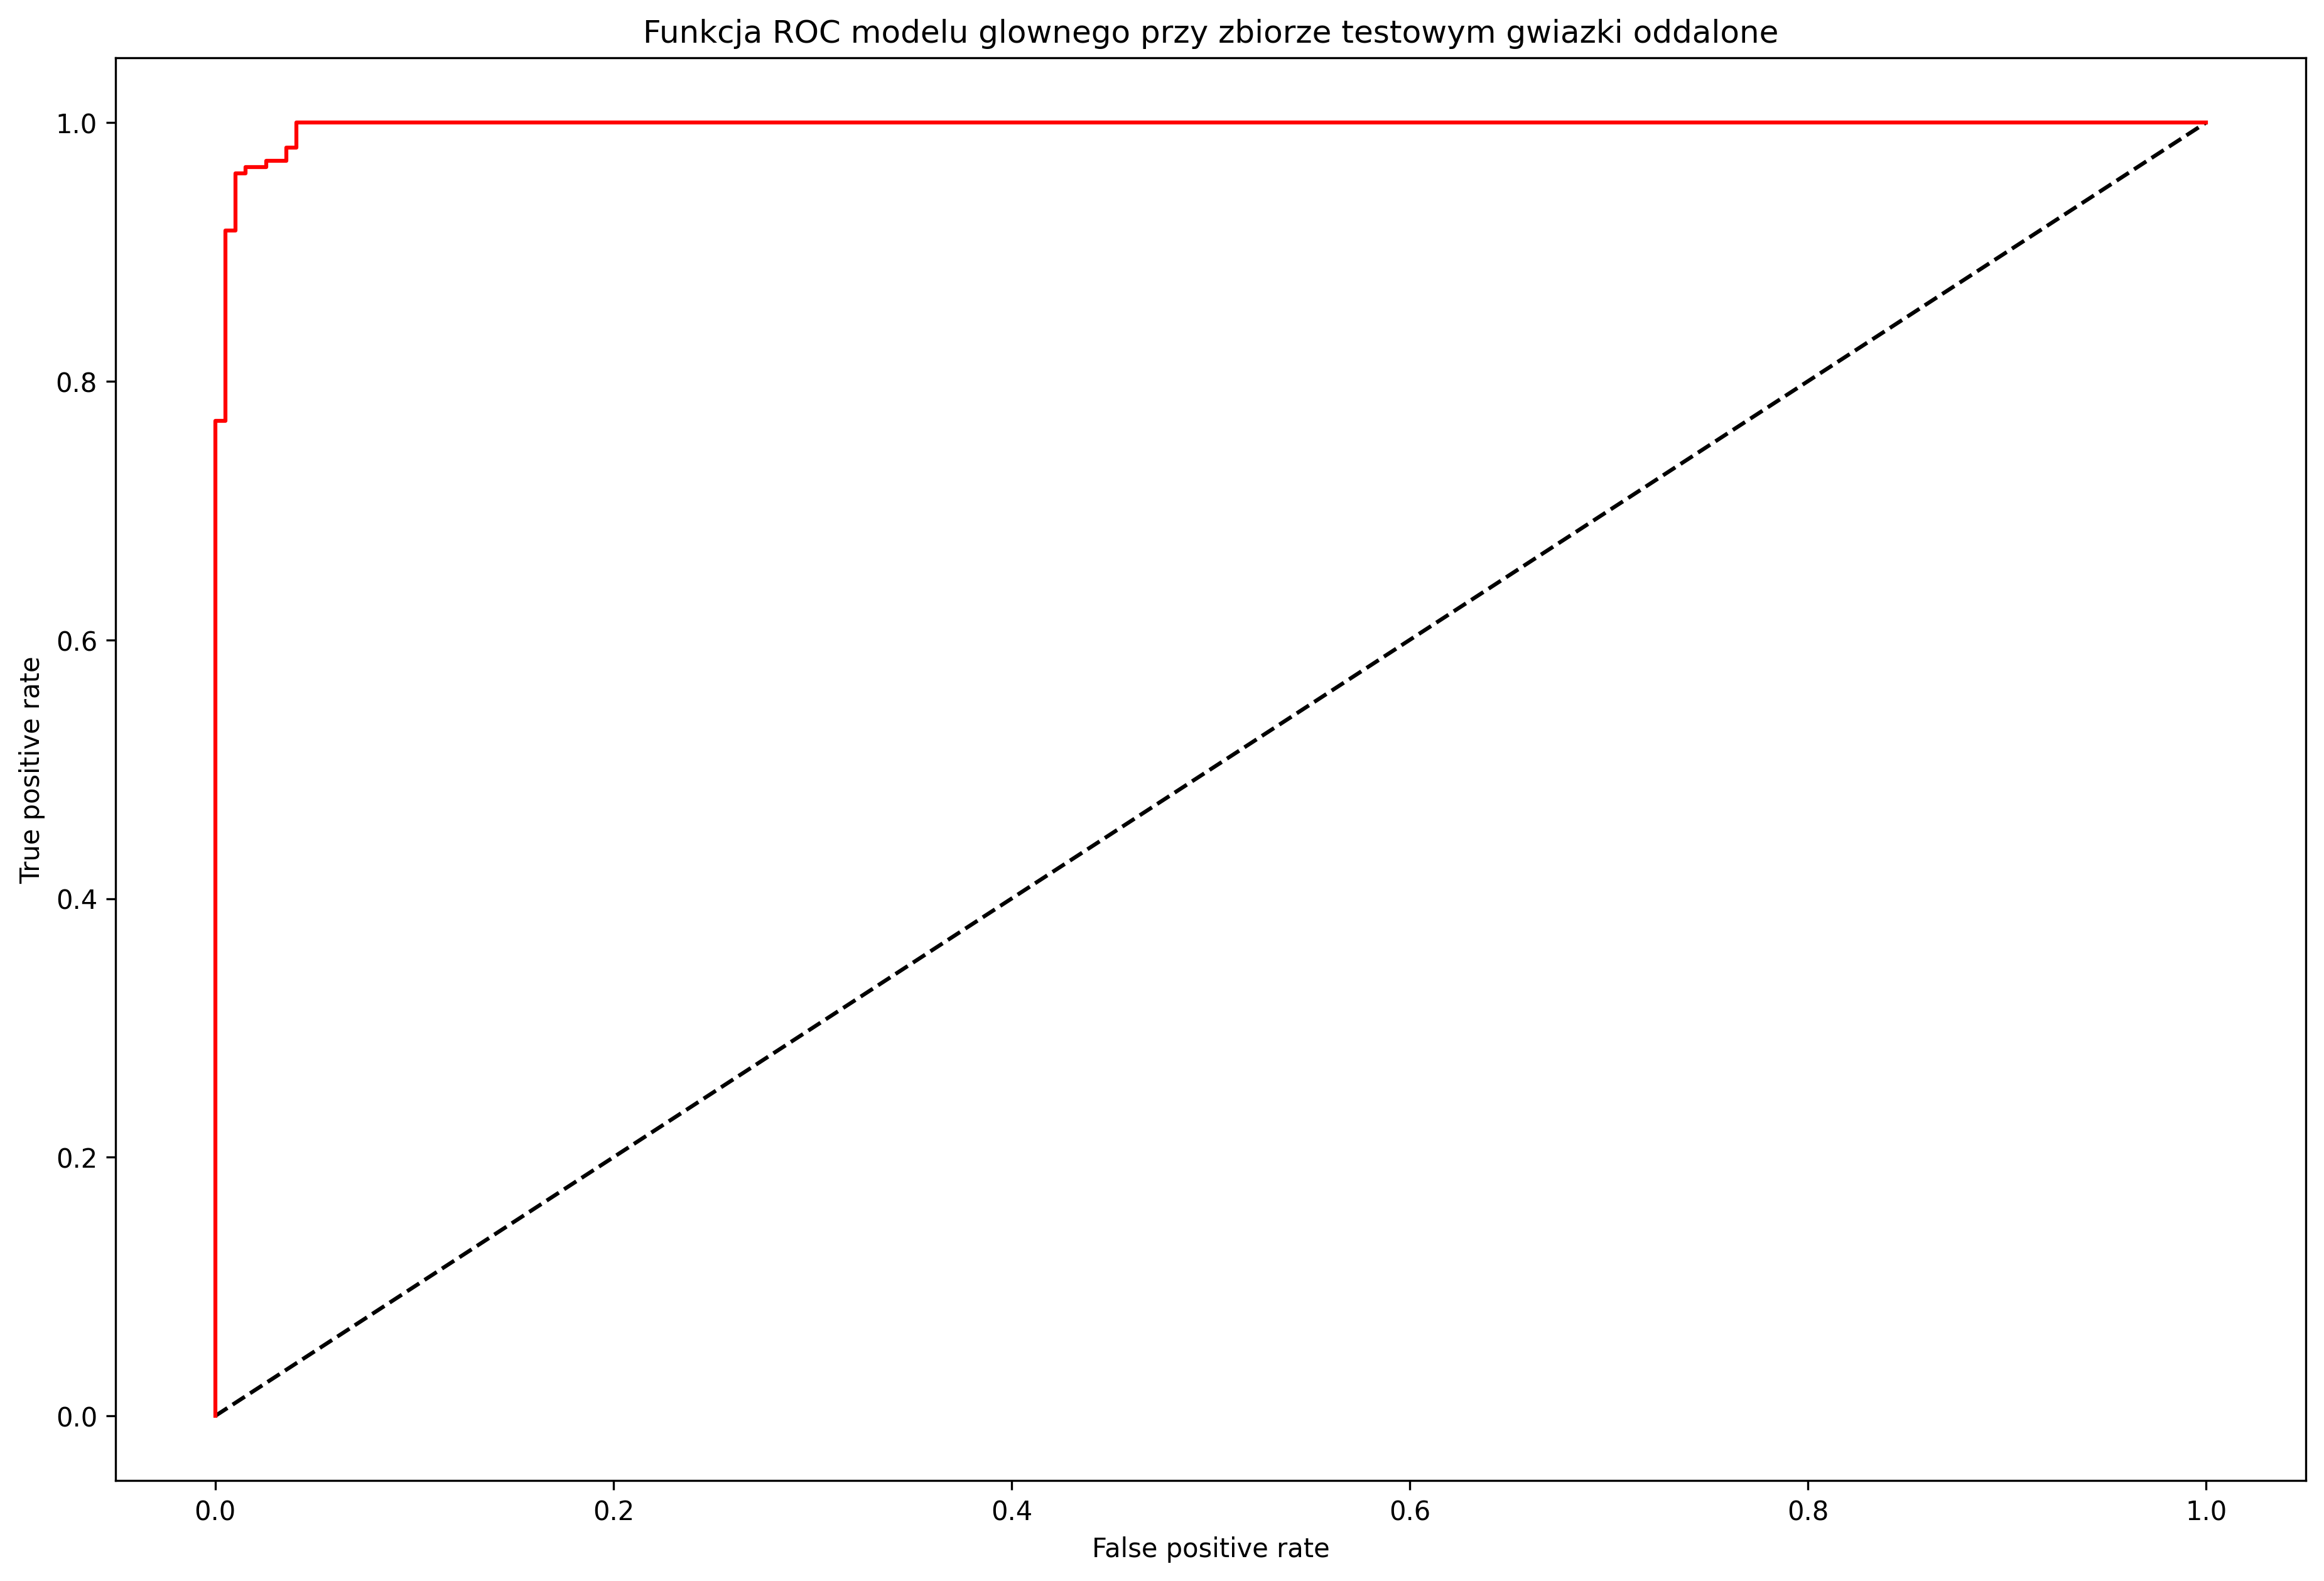

In [32]:
test_generator_2.reset()

tp = 0
tn = 0
fp = 0
fn = 0
threshold = 0.5
y_predict = []
y_true = []

for _ in range(400):
    image, labels = test_generator_2.next()
    true_label = int(labels[0])
    prediction = model.predict(image)[0][0]

    y_predict.append(prediction)
    y_true.append(true_label)

    if prediction >= threshold:
        if true_label == 1:
            tp = tp + 1
        else:
            fp = fp + 1
    else:
        if true_label == 0:
            tn = tn + 1
        else:
            fn = fn + 1

print("True positive: {} True negative: {} False Positive: {} False negative: {}".format(tp, tn, fp, fn))
fpr, tpr, thresholds = roc_curve(y_true, y_predict)

#ROC modelu
fig = plt.figure(figsize=(15, 10))
fig.set_dpi(300)
ax = plt.subplot(1, 1, 1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr, 'r')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Funkcja ROC modelu glownego przy zbiorze testowym gwiazki oddalone')
plt.show()
fig.savefig(model_glowny_dir + 'Funkcja ROC modelu glownego przy zbiorze testowym gwiazki oddalone.png')

## Test jedna gwiazda

In [33]:
path_test_3 = model_glowny_dir + "test_jedna_gwiazda"
test_generator_3 = data_gen_test.flow_from_directory(path_test_3, **flow_parameters_test)

Found 536 images belonging to 2 classes.


True positive: 197 True negative: 91 False Positive: 111 False negative: 1


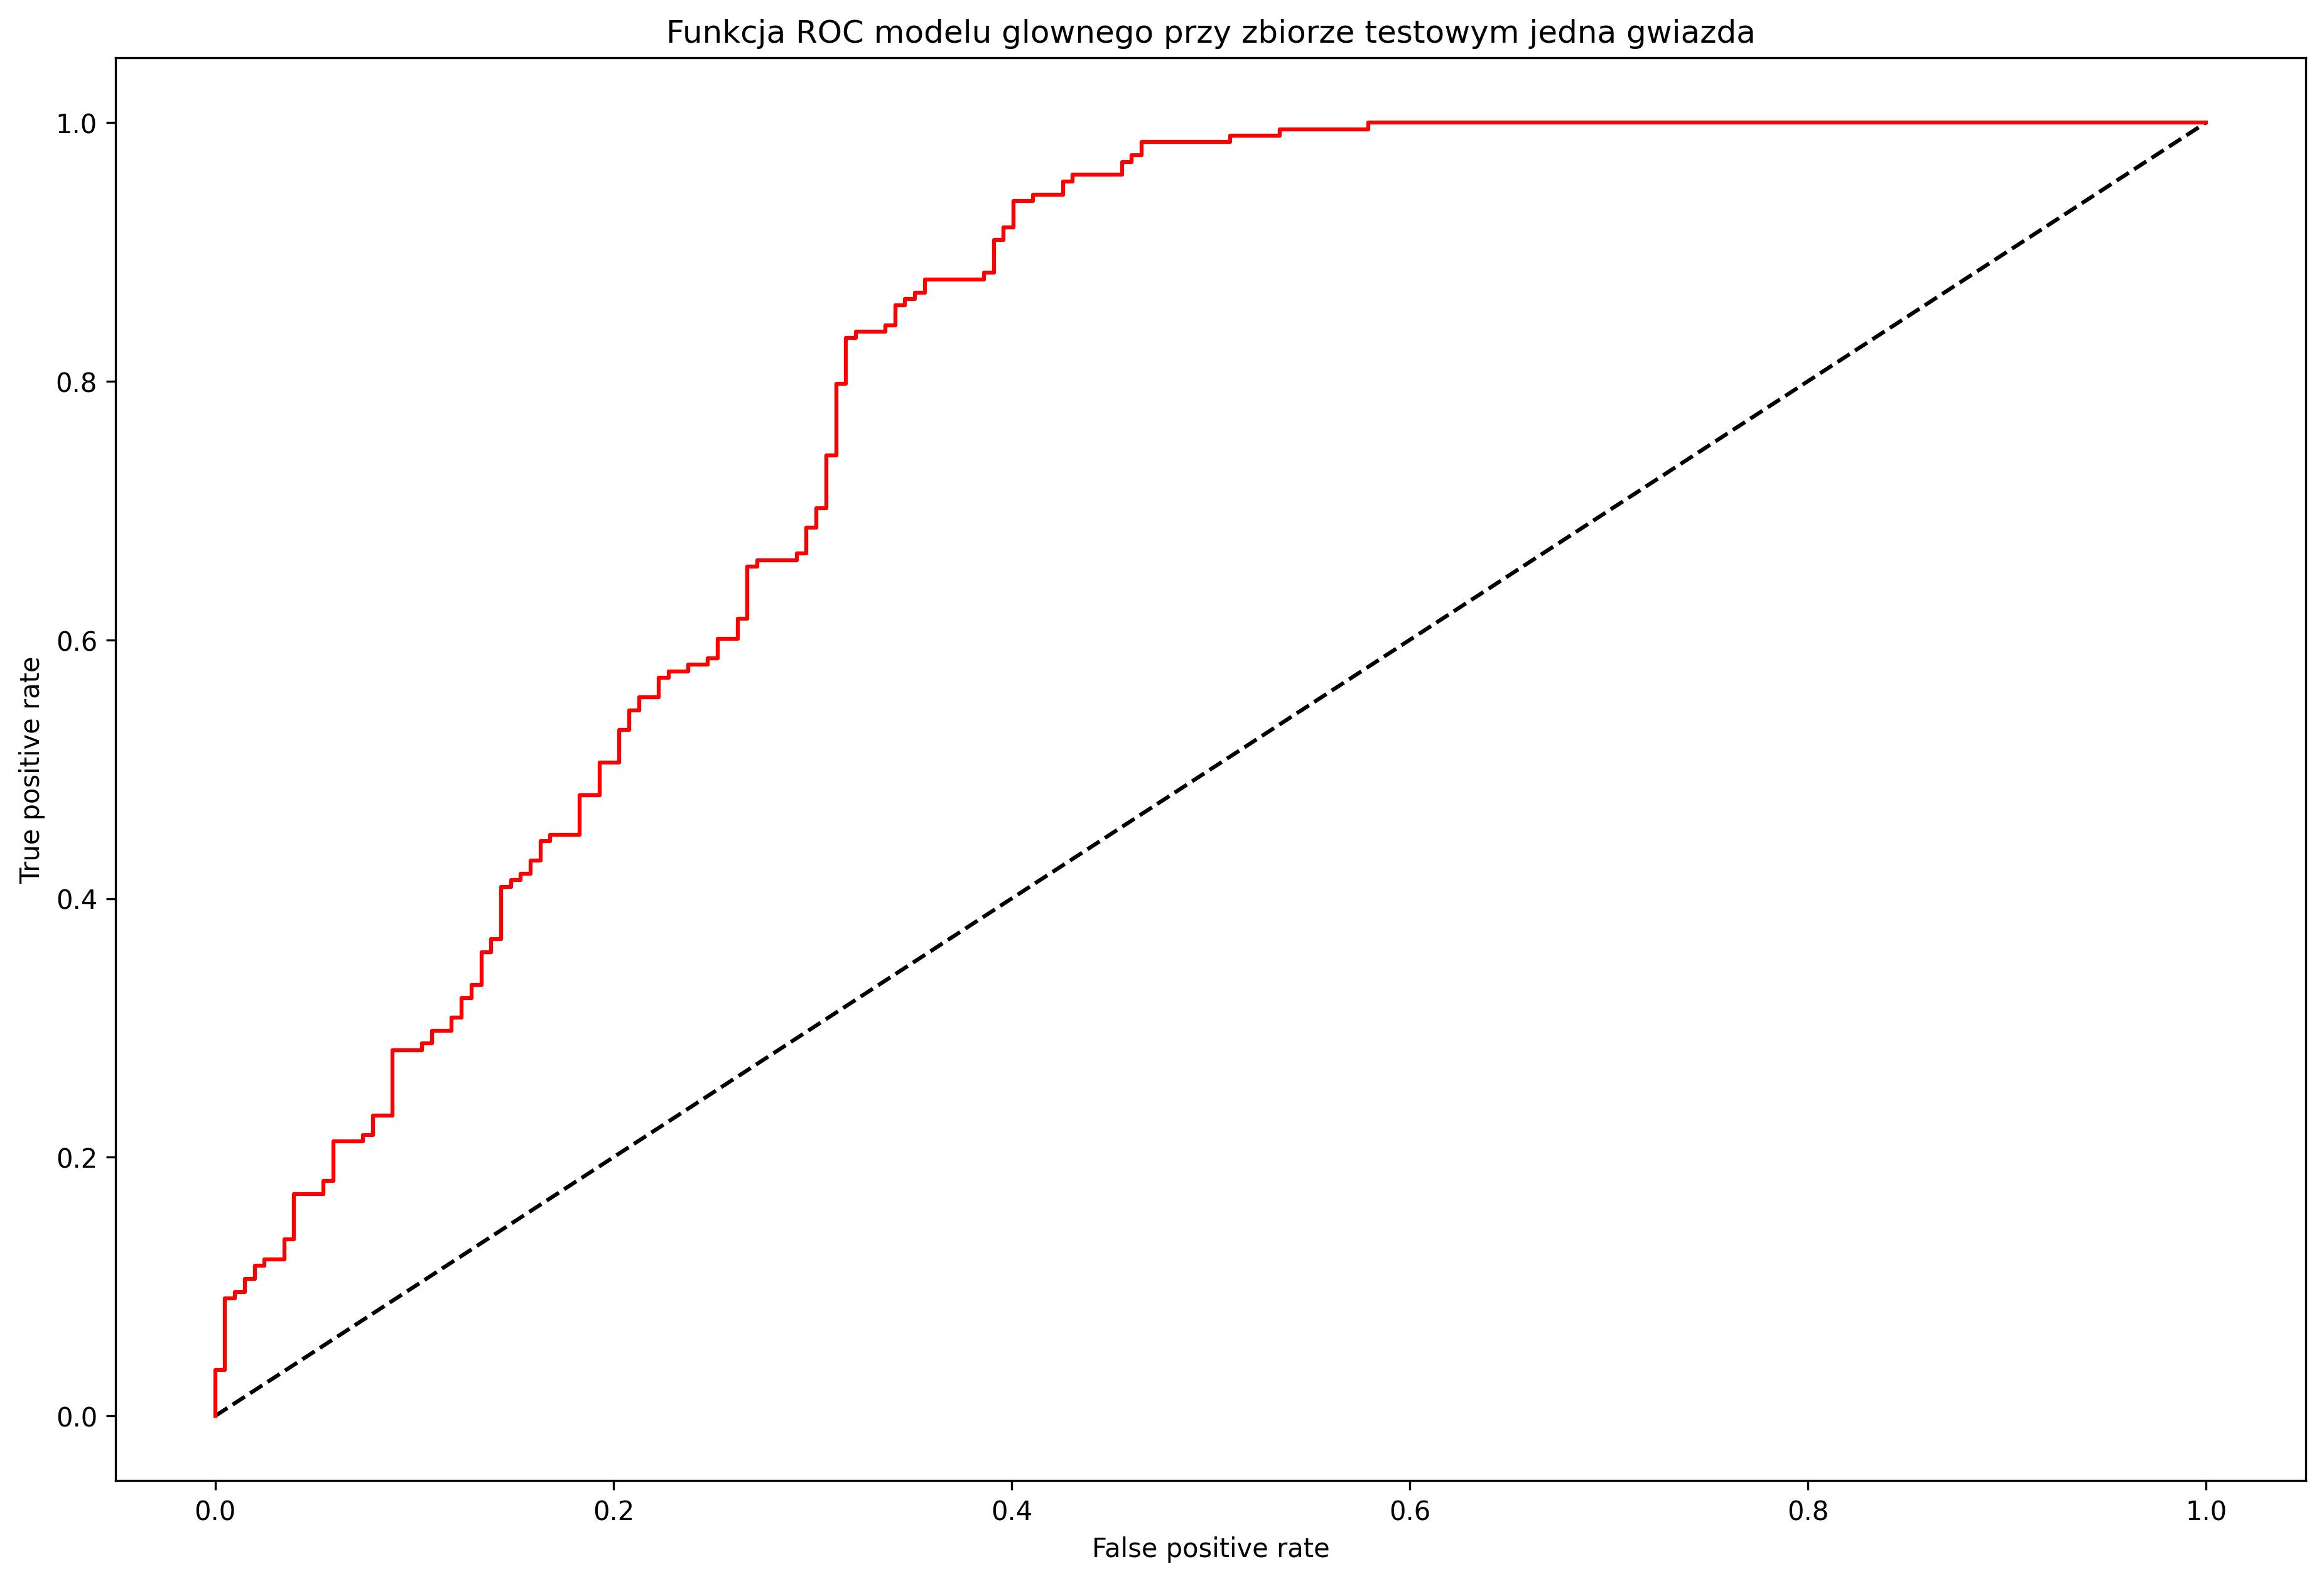

In [34]:
test_generator_3.reset()

tp = 0
tn = 0
fp = 0
fn = 0
threshold = 0.5
y_predict = []
y_true = []

for _ in range(400):
    image, labels = test_generator_3.next()
    true_label = int(labels[0])
    prediction = model.predict(image)[0][0]

    y_predict.append(prediction)
    y_true.append(true_label)

    if prediction >= threshold:
        if true_label == 1:
            tp = tp + 1
        else:
            fp = fp + 1
    else:
        if true_label == 0:
            tn = tn + 1
        else:
            fn = fn + 1

print("True positive: {} True negative: {} False Positive: {} False negative: {}".format(tp, tn, fp, fn))
fpr, tpr, thresholds = roc_curve(y_true, y_predict)

#ROC modelu
fig = plt.figure(figsize=(15, 10))
fig.set_dpi(300)
ax = plt.subplot(1, 1, 1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr, 'r')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Funkcja ROC modelu glownego przy zbiorze testowym jedna gwiazda')
plt.show()
fig.savefig(model_glowny_dir + 'Funkcja ROC modelu glownego przy zbiorze testowym jedna gwiazda.png')

## Test bez prozkow

In [35]:
path_test_4 = model_glowny_dir + "test_bez_prozkow"
test_generator_4 = data_gen_test.flow_from_directory(path_test_4, **flow_parameters_test)

Found 536 images belonging to 2 classes.


True positive: 185 True negative: 2 False Positive: 212 False negative: 1


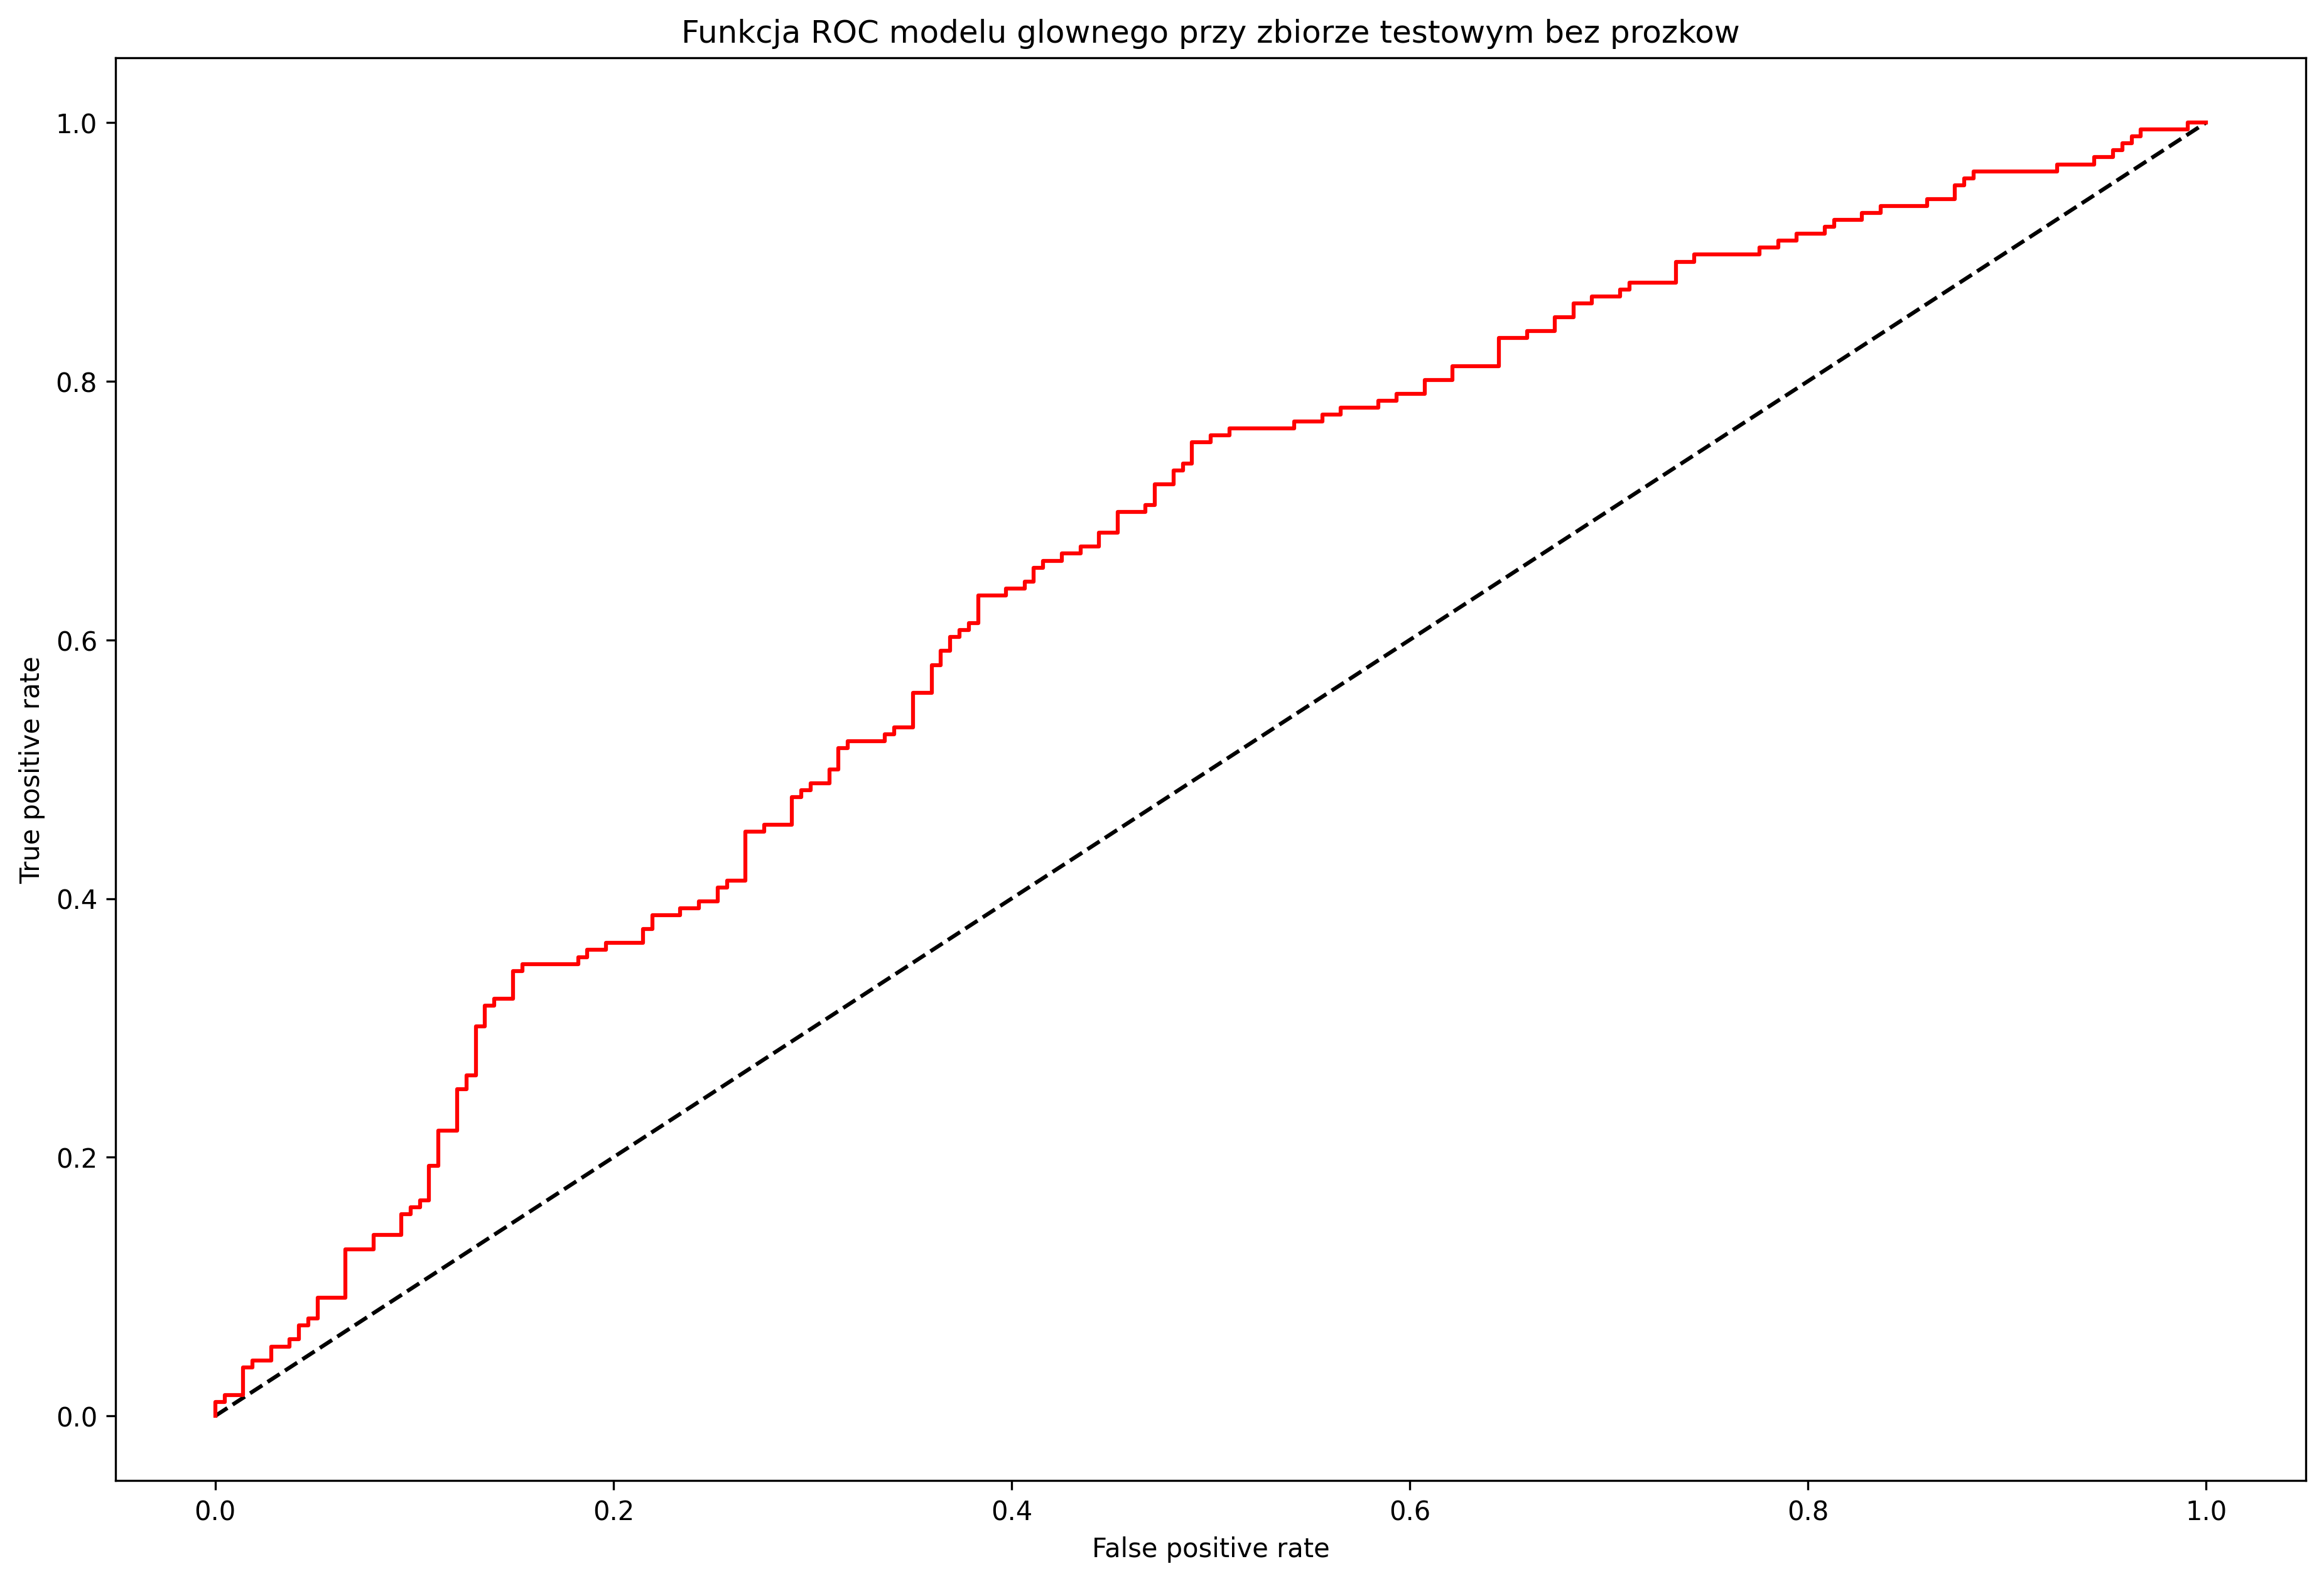

In [36]:
test_generator_4.reset()

flow_parameters_test
tp = 0
tn = 0
fp = 0
fn = 0
threshold = 0.5
y_predict = []
y_true = []

for _ in range(400):
    image, labels = test_generator_4.next()
    true_label = int(labels[0])
    prediction = model.predict(image)[0][0]

    y_predict.append(prediction)
    y_true.append(true_label)

    if prediction >= threshold:
        if true_label == 1:
            tp = tp + 1
        else:
            fp = fp + 1
    else:
        if true_label == 0:
            tn = tn + 1
        else:
            fn = fn + 1

print("True positive: {} True negative: {} False Positive: {} False negative: {}".format(tp, tn, fp, fn))
fpr, tpr, thresholds = roc_curve(y_true, y_predict)

#ROC modelu
fig = plt.figure(figsize=(15, 10))
fig.set_dpi(300)
ax = plt.subplot(1, 1, 1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr, 'r')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Funkcja ROC modelu glownego przy zbiorze testowym bez prozkow')
plt.show()
fig.savefig(model_glowny_dir + 'Funkcja ROC modelu glownego przy zbiorze testowym bez prozkow.png')